### Argonne (12/01/2022) Gain Determination

In [1]:
%matplotlib widget

In [2]:
import sys
import os
import time
import math as math
from datetime import datetime
import numpy as np
import astropy as ast
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.table import Table, hstack, vstack, Column
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import Angle
from astropy.time import Time
from photutils.aperture import EllipticalAnnulus, aperture_photometry
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import scipy.integrate
import scipy.constants
import scipy.special
from scipy import integrate
from scipy.optimize import curve_fit
import scipy.interpolate
from scipy.interpolate import CubicSpline
import glob2
import shutil
from IPython.display import clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import axes3d
from tqdm.notebook import tqdm as tqdm

import Utility3_4 as ut

pi = sp.constants.pi
k= sp.constants.k
q_e = sp.constants.e

DimY = 1096
DimX = 1936

DisectString = '\1/'
BackSlash = DisectString[0]
ForwardSlash = '/'

In [3]:
def gauss(x, norm, cent, width):
    return norm*np.exp(-(x-cent)**2 / (2*width**2))

def doubleGauss(x, n1, n2, c1, c2, w1, w2):
    return gauss(x, n1, c1, w1) + gauss(x, n2, c2, w2)

def quad(x, a, b, c):
    return (a * x**2) + (b * x) + c

def fitFunc(x, n1, n2, c1, c2, w1, w2, a, b, c):
    return doubleGauss(x, n1, n2, c1, c2, w1, w2) + quad(x, a, b, c)

def gaussBack(x, norm, cent, width, a, b, c):
    return gauss(x, norm, cent, width) + quad(x, a, b, c)

def line(x, m, b):
    return (m * x) + b

In [4]:
def ROItoPoints(ROI):
    
    x1 = ROI[0]
    y1 = ROI[2]

    x2 = ROI[1]
    y2 = ROI[2]
    
    x3 = ROI[1]
    y3 = ROI[3]
    
    x4 = ROI[0]
    y4 = ROI[3]
    
    x = [x1,x2,x3,x4]
    y = [y1,y2,y3,y4]
    
    return x, y

def MakeFileNamesList(datadirectory,filepattern):
    FileNamesList = glob2.glob(datadirectory + filepattern)
    
    return FileNamesList

def MakeImagesList(FileNamesList,IndexOfFitsImage):
    
    ImagesList = []
    
    for file in FileNamesList:
        
        #File = directory + file
        
        h = pyfits.open(file)
        img_data = h[IndexOfFitsImage].data
        header = h[IndexOfFitsImage].header
        '''
        exposure = header['EXPOSURE']
        gain = header['GAIN']
        DateAndTime = header['DATETIME']
        CamID = header['CAM_ID']
        CamFreeName = header['CAMFREE']
        '''
        image_and_metadata = [0,0,0,0,0,0]
        
        image_and_metadata[0] = img_data
        image_and_metadata[1] = header['EXPOSURE']
        image_and_metadata[2] = header['GAIN']
        image_and_metadata[3] = header['DATE']
        image_and_metadata[4] = header['TEMP']
        image_and_metadata[5] = file #Added Special Here the string of the corresponding file name
        #image_and_metadata[4] = header['CAM_ID']
        #image_and_metadata[5] = header['CAMFREE']
        
        ImagesList.append(image_and_metadata)
        
    return ImagesList

def MakeImagesListCSV(FileNamesList):
    
    ImagesList = []
    
    for file in FileNamesList:
        
        img_data = np.loadtxt(file, delimiter=',')
        
        image_and_metadata = [0,0,0,0,0,0]
        
        image_and_metadata[0] = img_data
        image_and_metadata[5] = file
        
        ImagesList.append(image_and_metadata)
        
    return ImagesList

def MakeCroppedImagesList(FileNamesList,ROI,IndexOfFitsImage):
    
    ImagesList = []
    
    for file in FileNamesList:
        
        #File = directory + file
        
        h = pyfits.open(file)
        img_data = h[IndexOfFitsImage].data
        header = h[IndexOfFitsImage].header

        image_and_metadata = [0,0,0,0,0,0]
        
        image_and_metadata[0] = img_data[ROI[2]:ROI[3],ROI[0]:ROI[1]]
        image_and_metadata[1] = header['EXPOSURE']
        image_and_metadata[2] = header['GAIN']
        image_and_metadata[3] = header['DATE']
        image_and_metadata[4] = header['TEMP']
        image_and_metadata[5] = file
        
        ImagesList.append(image_and_metadata)
        
    return ImagesList

def MakeHistogramSet(ToHistogramArray,MinX,MaxX,BinsPerUnitX,BinSize=False):
    HistBins = [MinX]
    PlotBins = [MinX]
    
    if BinSize != False:
        BinsPerUnitX = 1/BinSize
        BinsPerUnitX = int(BinsPerUnitX)
        ActualBinSize = 1/BinsPerUnitX
        print("Actual Bin Size: " + str(ActualBinSize))
        
    
    for i in range(int((MaxX-MinX)*BinsPerUnitX) + 1):
        HistBins.append(HistBins[i]+1/BinsPerUnitX)
        PlotBins.append(PlotBins[i]+1/BinsPerUnitX)
        
    HistBins = np.array(HistBins)
    HistBins = HistBins - 0.5/BinsPerUnitX
    
    PlotBins = np.array(PlotBins)
    PlotBins = PlotBins[:-1]
    
    theHistogram = np.histogram(ToHistogramArray, bins = HistBins)
    theHistogram = theHistogram[0]
    
    print("Only Valid if Integer: " + str((MaxX-MinX)*BinsPerUnitX))
    print("Bin Size: " + str(1/BinsPerUnitX))
    
    
    return theHistogram, PlotBins

### 490.5 eV

In [5]:
SetName = 'XM2_YP1_490p5eV'

Directory1 = 'SteadyStateDataSets/Gain_Data/' + SetName + ForwardSlash 
Directory2 = 'SteadyStateDataSets/Gain_Data/' + SetName + '/CroppedROI1/'
Directory3 = Directory1 + "BeamImages/"
Directory4 = Directory2 + "BeamImages/"

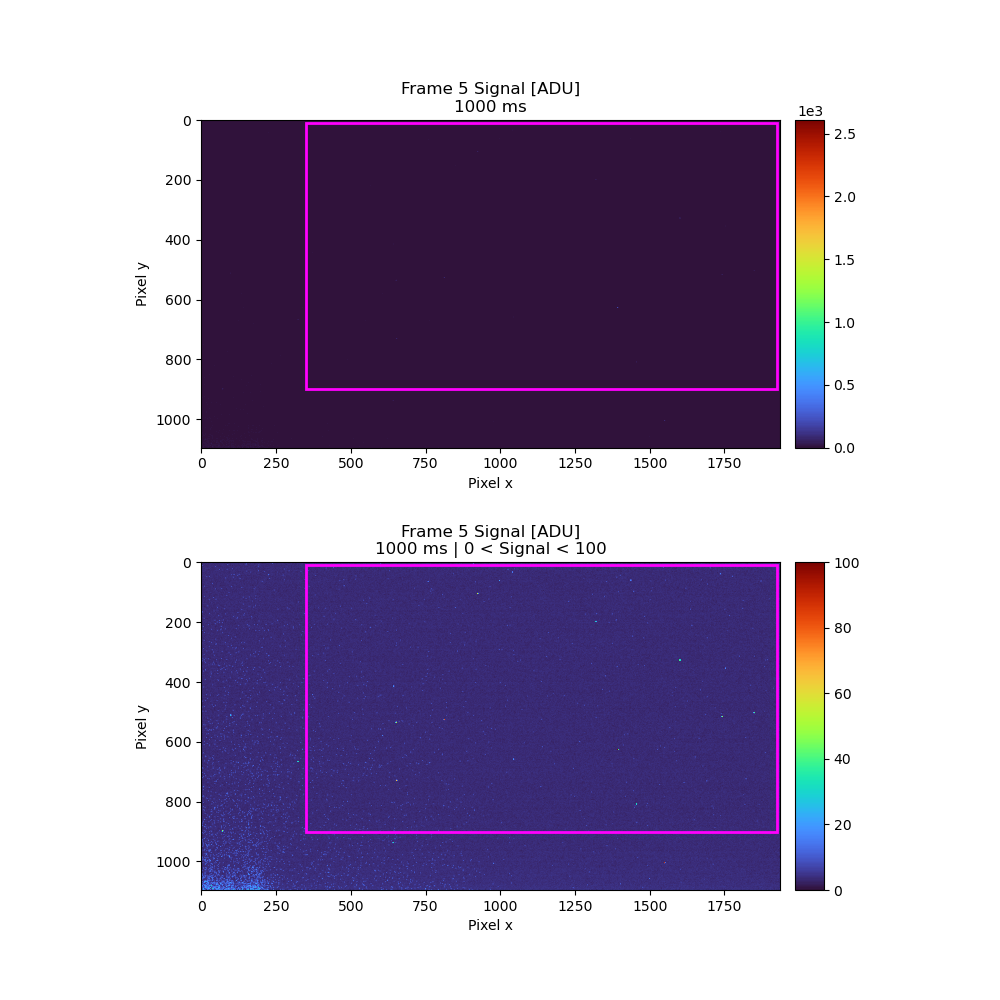

In [19]:
#Pick an ROI 
#ROI = [x0,x1,y0,y1]
ROI = [350,DimX-10,10,900]
#Draw the ROI to be sure
xROI, yROI = ROItoPoints(ROI)

#XM2_YP1_490p5eV
filepattern = '*.FTS'
FileNamesList = glob2.glob(Directory3 + filepattern)



#Grab The 5th image in the set
ReducedFileNamesList = [FileNamesList[4],FileNamesList[5]]
ReducedImagesList = ut.MakeImagesList(ReducedFileNamesList,1)
image_and_metadata = ReducedImagesList[0]
FifthImage = image_and_metadata[0]

f, ax = plt.subplots(2, 1)
im1 = ax[0].imshow(FifthImage, cmap='turbo')
divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes("right", size="5%", pad=0.15)
cbar1 = plt.colorbar(im1, cax=cax1)
cbar1.formatter.set_powerlimits((0, 0))
#cbar1.formatter.set_useMathText(True)
ax[0].fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=2, label = "ROI")
ax[0].set_xlabel('Pixel x')
ax[0].set_ylabel('Pixel y')
#ax[0].set_title('Sum of Dark Subtracted Frames [e$^-$] | CrSc 551.2 eV 300 ms')
ax[0].set_title(r"Frame 5 Signal [ADU]"
               "\n" r"1000 ms", loc = 'center')

im2 = ax[1].imshow(FifthImage, cmap='turbo',vmin = 0, vmax = 100)
divider = make_axes_locatable(ax[1])
cax2 = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im2, cax=cax2)
#cbar2 = plt.colorbar(im2, cax=cax2)
#cbar2.formatter.set_powerlimits((0, 0))
ax[1].fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=2, label = "ROI")
ax[1].set_xlabel('Pixel x')
ax[1].set_ylabel('Pixel y')
ax[1].set_title(r"Frame 5 Signal [ADU]"
               "\n" r"1000 ms | 0 < Signal < 100", loc = 'center')

plt.subplots_adjust(hspace = 0.35)

figure = plt.gcf()

figure.set_size_inches(10, 10)

plt.show()

In [7]:
#Grab darks and hots, and make a cropped image list.
DarkFrameName = 'MeanCS_Dark'
HotsArrayName = 'MasterHotsArray'
MeanDarkFrame = np.loadtxt(Directory1 + DarkFrameName + '.csv', delimiter=',')
HotsArray = np.loadtxt(Directory1 + HotsArrayName + '.csv', delimiter=',')

filepattern = '*.FTS'
FileNamesList = glob2.glob(Directory3 + filepattern)

CroppedImagesList = MakeCroppedImagesList(FileNamesList,ROI,1)

CroppedHotsArray = HotsArray[ROI[2]:ROI[3],ROI[0]:ROI[1]]
CroppedPrelimMeanDarkArray = MeanDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]]

print(np.shape(CroppedPrelimMeanDarkArray))

(890, 1576)


In [8]:
CroppedDimX = 1576
CroppedDimY = 890
IntegrationRegionSize = 5
thres = 20

OS_ROI1MasterDarkFrame, N_Array, SampleStdFrame, StandardErrorOfMeanFrame, SumDarkArray, DivideByArray = ut.MakeMasterIlluminatedDarkFrameStandard(CroppedImagesList,
                                                                CroppedPrelimMeanDarkArray,CroppedHotsArray,CroppedDimX,
                                                                CroppedDimY,IntegrationRegionSize,thres)

np.savetxt(Directory2 + 'OS_ROI1MasterDarkFrame4' +'.csv', OS_ROI1MasterDarkFrame, delimiter=',')

  0%|          | 0/385 [00:00<?, ?it/s]

C:\Users\Colin Packard\PythonWorkspace\Argonne12_01\Utility3_4.py:523: RuntimeWarning: invalid value encountered in sqrt
  SampleStdFrame = np.sqrt(MeanSquaredDark - (OS_MeanDarkFrame**2))


In [20]:
DarkFrameName = 'MeanCS_Dark'
MeanDarkFrame = np.loadtxt(Directory1 + DarkFrameName + '.csv', delimiter=',')
OS_ROI1MasterDarkFrame3 = np.loadtxt(Directory2 + 'OS_ROI1MasterDarkFrame4' +'.csv', delimiter=',')

print("----------------------------------------------------------------------------------")
print("OS_ROI_MasterDark")
print(OS_ROI1MasterDarkFrame3)
print("CS_ROI_MasterDark")
ROI_MeanDarkForTest = MeanDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]]
print(ROI_MeanDarkForTest)

CompositeDarkFrame = np.zeros(np.shape(MeanDarkFrame))
CompositeDarkFrame = np.where(CompositeDarkFrame == 0, MeanDarkFrame, CompositeDarkFrame)
CompositeDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]] = OS_ROI1MasterDarkFrame3

print("CompositeDarkFrame")
print(CompositeDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]])
ROI_MeanDarkForTest = MeanDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]]
print("CS_ROI_MasterDark_Again")
print(ROI_MeanDarkForTest)

print("Mean Signal CS_Dark")
print(np.mean(MeanDarkFrame))
print("Mean Signal OS_Dark Composite")
print(np.mean(CompositeDarkFrame))

----------------------------------------------------------------------------------
OS_ROI_MasterDark
[[3.66404199 3.61578947 3.63324538 ... 3.62337662 3.65454545 3.59220779]
 [3.60158311 3.14021164 3.5994695  ... 3.68407311 3.92167102 3.59530026]
 [3.5596817  3.70212766 3.54933333 ... 3.75718016 3.59791123 3.32637076]
 ...
 [3.49865952 3.5273224  3.41340782 ... 3.32114883 3.47780679 3.54166667]
 [3.58933333 3.7100271  3.65373961 ... 3.42708333 3.5390625  3.35416667]
 [3.48138298 3.63342318 3.73424658 ... 3.875      3.57291667 3.45052083]]
CS_ROI_MasterDark
[[3.54901961 3.64705882 3.2745098  ... 3.58823529 3.37254902 3.31372549]
 [3.74509804 3.2745098  3.64705882 ... 3.68627451 3.74509804 3.68627451]
 [3.41176471 3.49019608 3.43137255 ... 3.47058824 3.74509804 3.33333333]
 ...
 [3.66666667 3.47058824 3.45098039 ... 3.17647059 3.54901961 3.33333333]
 [3.49019608 3.52941176 3.88235294 ... 3.35294118 3.74509804 3.60784314]
 [3.49019608 3.70588235 3.74509804 ... 3.88235294 3.47058824 3.3333

In [22]:
#Making and saving composite dark frame
DarkFrameName = 'MeanCS_Dark'
MeanDarkFrame = np.loadtxt(Directory1 + DarkFrameName + '.csv', delimiter=',')
OS_ROI1MasterDarkFrame3 = np.loadtxt(Directory2 + 'OS_ROI1MasterDarkFrame4' +'.csv', delimiter=',')

CompositeDarkFrame = np.zeros(np.shape(MeanDarkFrame))
CompositeDarkFrame = np.where(CompositeDarkFrame == 0, MeanDarkFrame, CompositeDarkFrame)
CompositeDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]] = OS_ROI1MasterDarkFrame3

np.savetxt(Directory2 + 'OS_ROI1CompositeMasterDarkFrame2' +'.csv', CompositeDarkFrame, delimiter=',')

In [28]:
ROI = [350,DimX-10,10,900]
IntegrationRegionSize = 3
thres = 20
thresp = -1000000
IntegrationRegionSize = 5

filepattern = '*.FTS'
FileNamesList = glob2.glob(Directory3 + filepattern)
ImagesList = MakeImagesList(FileNamesList,1)

CompositeDarkFrame = np.loadtxt(Directory2 + 'OS_ROI1CompositeMasterDarkFrame2' +'.csv', delimiter=',')

AllEventSignals, FrameMeanEventSignals, AssociatedFileNames = ut.EventFinderSteveB(ImagesList,
                                                                                   ROI, CompositeDarkFrame, HotsArray,
                                                                                   IntegrationRegionSize, thres,
                                                                                   thresp, verbose=False, diagonals=False)

  0%|          | 0/385 [00:00<?, ?it/s]

In [29]:
np.savetxt(Directory2 + 'AllEventSignalsROI1_OS_CompositeDark2' +'.csv', AllEventSignals, delimiter=',')

In [30]:
ToHistogramArray = np.loadtxt(Directory2 + 'AllEventSignalsROI1_OS_CompositeDark2' +'.csv', delimiter=',')
MinX = 0
MaxX = 200
BinsPerUnitX = 1
HistogramY_490p5, BinsX_490p5 = MakeHistogramSet(ToHistogramArray,MinX,MaxX,BinsPerUnitX,BinSize=False)

Only Valid if Integer: 200
Bin Size: 1.0


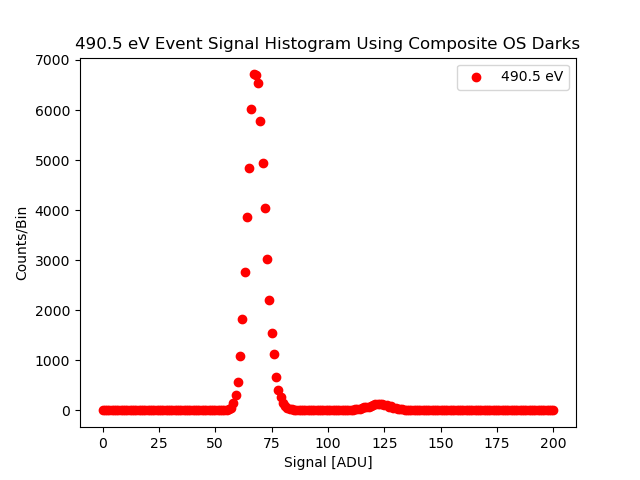

In [31]:
plt.figure('490.5 eV Event Signal Histogram a1')
plt.clf()
#plt.plot(BinsX_520,HistogramY_520, color = 'black', label = '490.5 eV')
plt.scatter(BinsX_490p5,HistogramY_490p5, color = 'red', label = '490.5 eV')
plt.title('490.5 eV Event Signal Histogram Using Composite OS Darks')
plt.xlabel('Signal [ADU]')
plt.ylabel('Counts/Bin')
plt.legend()
plt.show()

In [32]:
#Now finding events using only the mean CS dark frame trying without the compositing using just CS darks
ROI = [350,DimX-10,10,900]
IntegrationRegionSize = 3
thres = 20
thresp = -1000000
IntegrationRegionSize = 5

filepattern = '*.FTS'
FileNamesList = glob2.glob(Directory3 + filepattern)
ImagesList = MakeImagesList(FileNamesList,1)


AllEventSignals2, FrameMeanEventSignals2, AssociatedFileNames2 = ut.EventFinderSteveB(ImagesList,
                                                                                   ROI, MeanDarkFrame, HotsArray,
                                                                                   IntegrationRegionSize, thres,
                                                                                   thresp, verbose=False, diagonals=False)

  0%|          | 0/385 [00:00<?, ?it/s]

In [33]:
np.savetxt(Directory2 + 'AllEventSignalsROI1_CS_MeanDark2' +'.csv', AllEventSignals2, delimiter=',')

In [34]:
ToHistogramArray = np.loadtxt(Directory2 + 'AllEventSignalsROI1_CS_MeanDark2' +'.csv', delimiter=',')
MinX = 0
MaxX = 200
BinsPerUnitX = 1
HistogramY_490p5_CS, BinsX_490p5_CS = MakeHistogramSet(ToHistogramArray,MinX,MaxX,BinsPerUnitX,BinSize=False)

Only Valid if Integer: 200
Bin Size: 1.0


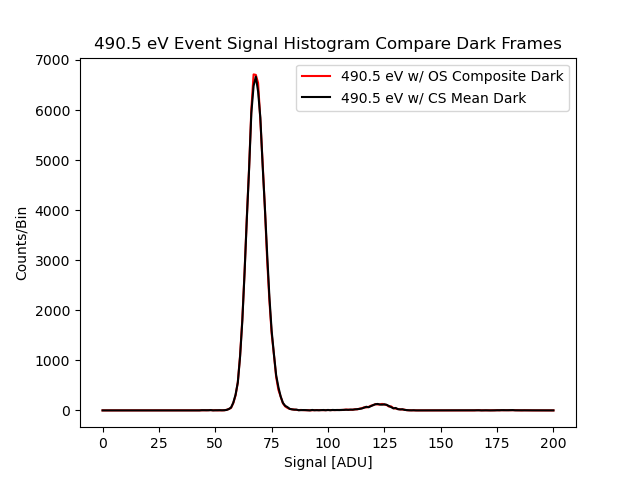

In [35]:
plt.figure('490.5 eVEvent Signal Histogram compare 1')
plt.clf()
plt.plot(BinsX_490p5,HistogramY_490p5, color = 'red', label = '490.5 eV w/ OS Composite Dark')
plt.plot(BinsX_490p5_CS,HistogramY_490p5_CS, color = 'black', label = '490.5 eV w/ CS Mean Dark')
#plt.scatter(BinsX_520,HistogramY_520, color = 'red', label = '520.0 eV')
plt.title('490.5 eV Event Signal Histogram Compare Dark Frames')
plt.xlabel('Signal [ADU]')
plt.ylabel('Counts/Bin')
plt.legend()
plt.show()

[6.74460877e+03 1.23376781e+02 6.81220873e+01 1.22622323e+02
 3.87061127e+00 5.12479186e+00]
[2.28926589e+01 1.98951699e+01 1.51701142e-02 9.54247446e-01
 1.51701141e-02 9.54247439e-01]
[6.63713330e+03 1.23119856e+02 6.81694791e+01 1.22671618e+02
 3.92449038e+00 5.09268360e+00]
[2.22332855e+01 1.95173067e+01 1.51801620e-02 9.32211936e-01
 1.51801621e-02 9.32211931e-01]


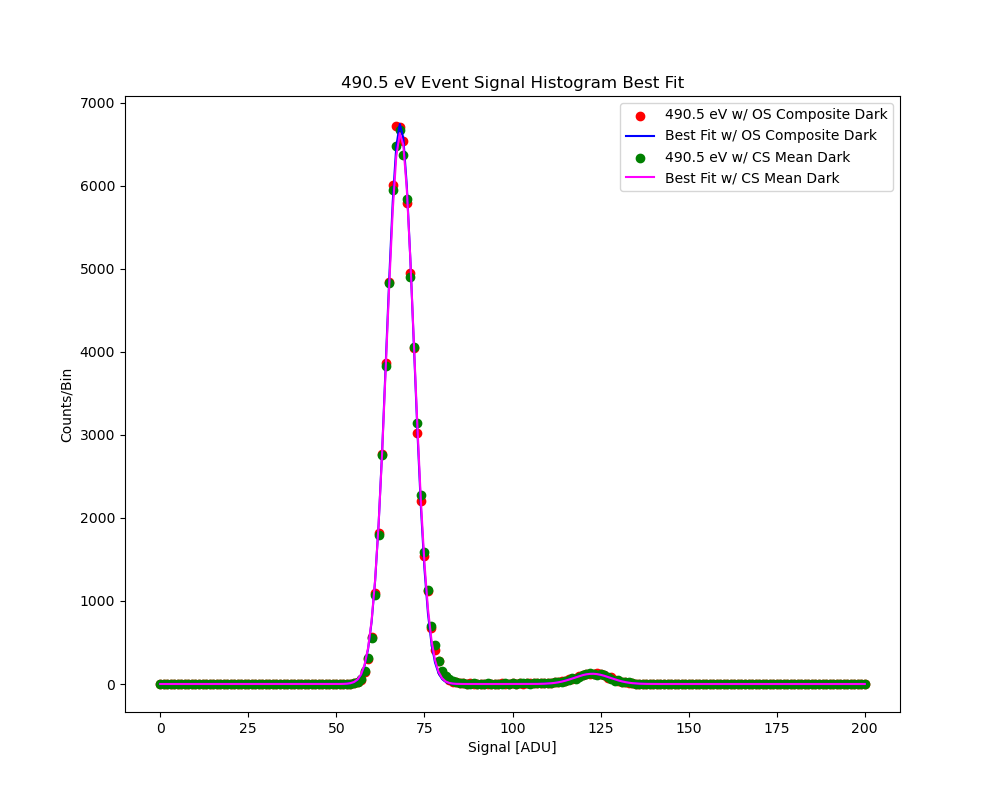

_________________________________
 Using the OS Composite Darks
 -----------------------------
 Centroid: 68.12
 Centroid Err: 0.02
 Standard Deviation: 3.87
 Standard Deviation Error: 0.02
_________________________________
 Using the CS Mean Darks
 -----------------------------
 Centroid: 68.17
 Centroid Err: 0.02
 Standard Deviation: 3.92
 Standard Deviation Error: 0.02


In [38]:
#Curve Fitting 
#[n1, n2, c1, c2, w1, w2, a, b, c]
test = [6700, 150, 68, 122, 1, 1]

xAxis = BinsX_490p5
yAxis = HistogramY_490p5

popt, pcov = curve_fit(doubleGauss, xAxis, yAxis, p0=test)
perr = np.sqrt(np.diag(pcov))
print(popt)
print(perr)

test2 = [6700, 150, 68, 122, 1, 1]

xAxis2 = BinsX_490p5_CS
yAxis2 = HistogramY_490p5_CS

popt2, pcov2 = curve_fit(doubleGauss, xAxis2, yAxis2, p0=test2)
perr2 = np.sqrt(np.diag(pcov2))
print(popt2)
print(perr2)

plt.figure(figsize=(10,8))
plt.clf()
plt.scatter(BinsX_490p5,HistogramY_490p5, color = 'r', label = '490.5 eV w/ OS Composite Dark')
plt.plot(xAxis,doubleGauss(xAxis, *popt), color = 'b', label = 'Best Fit w/ OS Composite Dark')
plt.scatter(BinsX_490p5_CS,HistogramY_490p5_CS, color = 'green', label = '490.5 eV w/ CS Mean Dark')
plt.plot(xAxis2,doubleGauss(xAxis2, *popt2), color = 'magenta', label = 'Best Fit w/ CS Mean Dark')
plt.title('490.5 eV Event Signal Histogram Best Fit')
plt.xlabel('Signal [ADU]')
plt.ylabel('Counts/Bin')
plt.legend()
plt.show()

Centroid = popt[2]
CentroidErr = perr[2]
Sigma = popt[4]
SigmaErr = perr[4]

Centroid2 = popt2[2]
CentroidErr2 = perr2[2]
Sigma2 = popt2[4]
SigmaErr2 = perr2[4]

print("_________________________________")
print(" Using the OS Composite Darks")
print(" -----------------------------")
print(" Centroid: " + str(round(Centroid,2)))
print(" Centroid Err: " + str(round(CentroidErr,2)))
print(" Standard Deviation: " + str(round(Sigma,2)))
print(" Standard Deviation Error: " + str(round(SigmaErr,2)))

print("_________________________________")
print(" Using the CS Mean Darks")
print(" -----------------------------")
print(" Centroid: " + str(round(Centroid2,2)))
print(" Centroid Err: " + str(round(CentroidErr2,2)))
print(" Standard Deviation: " + str(round(Sigma2,2)))
print(" Standard Deviation Error: " + str(round(SigmaErr2,2)))

[ 6.74309143e+03  1.15768535e+02  6.81069037e+01  1.22722534e+02
  3.85893252e+00 -4.43532102e+00 -1.98501177e-03  4.05013931e-01
 -8.31861230e+00]
[2.34076037e+01 2.19252029e+01 1.52269742e-02 9.51061061e-01
 1.59398175e-02 1.00638609e+00 1.29477836e-03 2.65924170e-01
 1.05742489e+01]
[ 6.62817627e+03  1.15925785e+02  6.81726424e+01  1.22774131e+02
  3.91774837e+00 -4.44029977e+00 -1.88964855e-03  3.89677076e-01
 -8.46169001e+00]
[2.25738026e+01 2.12911264e+01 1.51622419e-02 9.22791480e-01
 1.58855351e-02 9.76672468e-01 1.25910505e-03 2.58540420e-01
 1.02721012e+01]


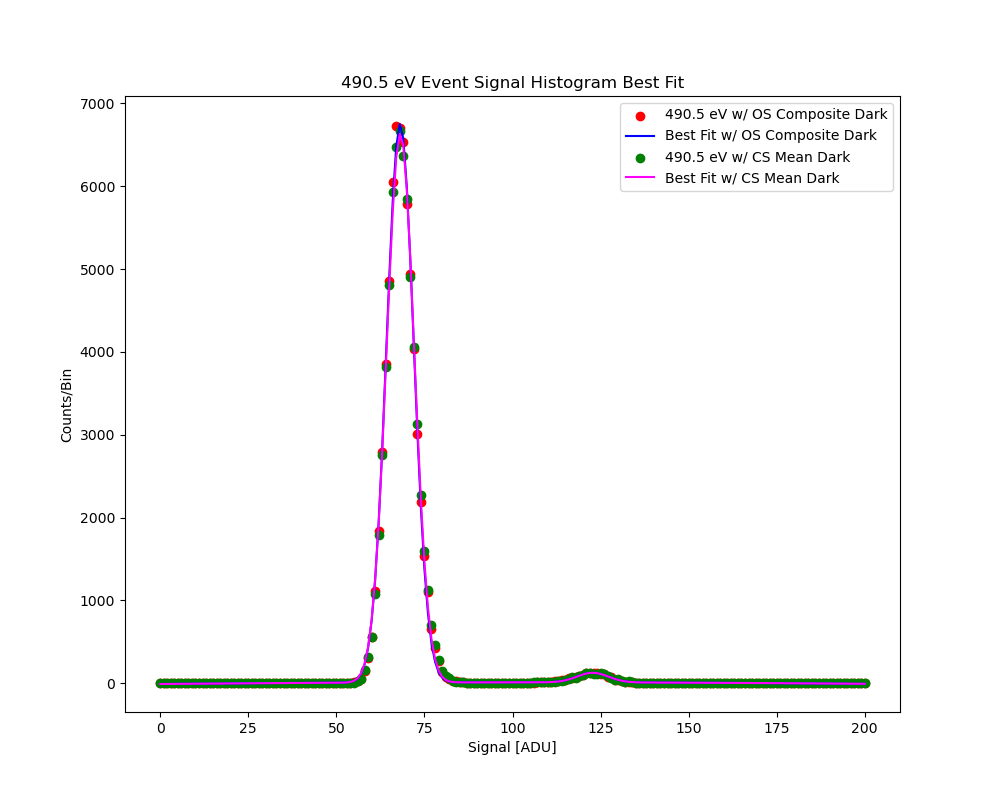

_________________________________
 Using the OS Composite Darks
 -----------------------------
 Centroid: 68.11
 Centroid Err: 0.02
 Standard Deviation: 3.86
 Standard Deviation Error: 0.02
_________________________________
 Using the CS Mean Darks
 -----------------------------
 Centroid: 68.17
 Centroid Err: 0.02
 Standard Deviation: 3.92
 Standard Deviation Error: 0.02


In [17]:
#Old Results 3x3 non master hots Curve Fitting 
#[n1, n2, c1, c2, w1, w2, a, b, c]
test = [6700, 150, 68, 122, 1, 1, 0, 0, 1]

xAxis = BinsX_490p5
yAxis = HistogramY_490p5

popt, pcov = curve_fit(fitFunc, xAxis, yAxis, p0=test)
perr = np.sqrt(np.diag(pcov))
print(popt)
print(perr)

test2 = [6700, 150, 68, 122, 1, 1, 0, 0, 1]

xAxis2 = BinsX_490p5_CS
yAxis2 = HistogramY_490p5_CS

popt2, pcov2 = curve_fit(fitFunc, xAxis2, yAxis2, p0=test2)
perr2 = np.sqrt(np.diag(pcov2))
print(popt2)
print(perr2)

plt.figure(figsize=(10,8))
plt.clf()
plt.scatter(BinsX_490p5,HistogramY_490p5, color = 'r', label = '490.5 eV w/ OS Composite Dark')
plt.plot(xAxis,fitFunc(xAxis, *popt), color = 'b', label = 'Best Fit w/ OS Composite Dark')
plt.scatter(BinsX_490p5_CS,HistogramY_490p5_CS, color = 'green', label = '490.5 eV w/ CS Mean Dark')
plt.plot(xAxis2,fitFunc(xAxis2, *popt2), color = 'magenta', label = 'Best Fit w/ CS Mean Dark')
plt.title('490.5 eV Event Signal Histogram Best Fit')
plt.xlabel('Signal [ADU]')
plt.ylabel('Counts/Bin')
plt.legend()
plt.show()

Centroid = popt[2]
CentroidErr = perr[2]
Sigma = popt[4]
SigmaErr = perr[4]

Centroid2 = popt2[2]
CentroidErr2 = perr2[2]
Sigma2 = popt2[4]
SigmaErr2 = perr2[4]

print("_________________________________")
print(" Using the OS Composite Darks")
print(" -----------------------------")
print(" Centroid: " + str(round(Centroid,2)))
print(" Centroid Err: " + str(round(CentroidErr,2)))
print(" Standard Deviation: " + str(round(Sigma,2)))
print(" Standard Deviation Error: " + str(round(SigmaErr,2)))

print("_________________________________")
print(" Using the CS Mean Darks")
print(" -----------------------------")
print(" Centroid: " + str(round(Centroid2,2)))
print(" Centroid Err: " + str(round(CentroidErr2,2)))
print(" Standard Deviation: " + str(round(Sigma2,2)))
print(" Standard Deviation Error: " + str(round(SigmaErr2,2)))

***
### 520.0 eV

In [39]:
SetName = 'X0_Y0_520eV'

Directory1 = 'SteadyStateDataSets/Gain_Data/' + SetName + ForwardSlash 
Directory2 = 'SteadyStateDataSets/Gain_Data/' + SetName + '/CroppedROI1/'
Directory3 = Directory1 + "BeamImages/"
Directory4 = Directory2 + "BeamImages/"

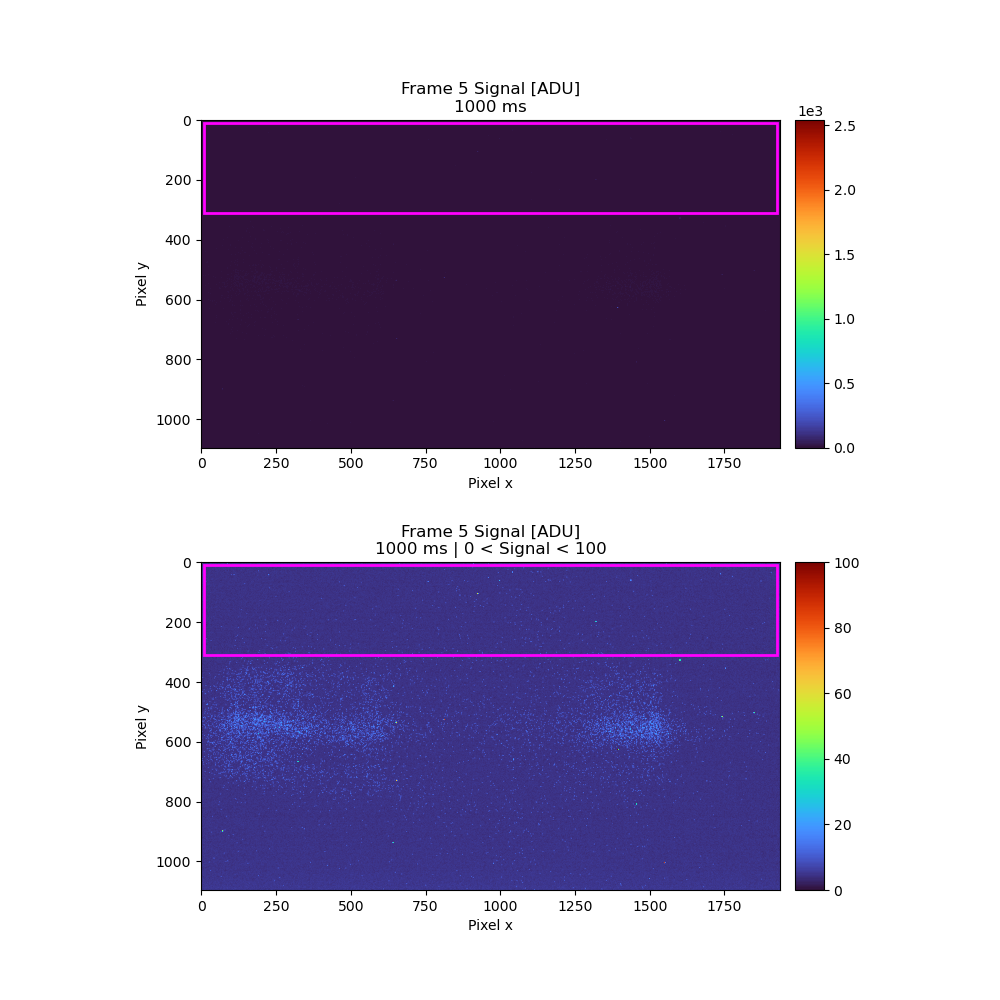

In [40]:
#Pick an ROI 
#ROI = [x0,x1,y0,y1]
ROI = [10,DimX-10,10,310]
#Draw the ROI to be sure
xROI, yROI = ROItoPoints(ROI)

#X0_Y0_520eV
filepattern = '*.FTS'
FileNamesList = glob2.glob(Directory3 + filepattern)

#Grab Darks and Hots
DarkFrameName = 'PrelimMeanCS_Dark2'
HotsArrayName = 'MasterHotsArray'
MeanDarkFrame = np.loadtxt(Directory1 + DarkFrameName + '.csv', delimiter=',')
HotsArray = np.loadtxt(Directory1 + HotsArrayName + '.csv', delimiter=',')

#Grab The 5th image in the set
ReducedFileNamesList = [FileNamesList[4],FileNamesList[5]]
ReducedImagesList = ut.MakeImagesList(ReducedFileNamesList,1)
image_and_metadata = ReducedImagesList[0]
FifthImage = image_and_metadata[0]

f, ax = plt.subplots(2, 1)
im1 = ax[0].imshow(FifthImage, cmap='turbo')
divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes("right", size="5%", pad=0.15)
cbar1 = plt.colorbar(im1, cax=cax1)
cbar1.formatter.set_powerlimits((0, 0))
#cbar1.formatter.set_useMathText(True)
ax[0].fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=2, label = "ROI")
ax[0].set_xlabel('Pixel x')
ax[0].set_ylabel('Pixel y')
#ax[0].set_title('Sum of Dark Subtracted Frames [e$^-$] | CrSc 551.2 eV 300 ms')
ax[0].set_title(r"Frame 5 Signal [ADU]"
               "\n" r"1000 ms", loc = 'center')

im2 = ax[1].imshow(FifthImage, cmap='turbo',vmin = 0, vmax = 100)
divider = make_axes_locatable(ax[1])
cax2 = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im2, cax=cax2)
#cbar2 = plt.colorbar(im2, cax=cax2)
#cbar2.formatter.set_powerlimits((0, 0))
ax[1].fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=2, label = "ROI")
ax[1].set_xlabel('Pixel x')
ax[1].set_ylabel('Pixel y')
ax[1].set_title(r"Frame 5 Signal [ADU]"
               "\n" r"1000 ms | 0 < Signal < 100", loc = 'center')

plt.subplots_adjust(hspace = 0.35)

figure = plt.gcf()

figure.set_size_inches(10, 10)

plt.show()

In [11]:
#Grab darks and hots, and make a cropped image list.
DarkFrameName = 'PrelimMeanCS_Dark2'
HotsArrayName = 'MasterHotsArray'
MeanDarkFrame = np.loadtxt(Directory1 + DarkFrameName + '.csv', delimiter=',')
HotsArray = np.loadtxt(Directory1 + HotsArrayName + '.csv', delimiter=',')

filepattern = '*.FTS'
FileNamesList = glob2.glob(Directory3 + filepattern)

CroppedImagesList = MakeCroppedImagesList(FileNamesList,ROI,1)

CroppedHotsArray = HotsArray[ROI[2]:ROI[3],ROI[0]:ROI[1]]
CroppedPrelimMeanDarkArray = MeanDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]]

print(np.shape(CroppedPrelimMeanDarkArray))

(300, 1916)


In [12]:
CroppedDimX = 1916
CroppedDimY = 300
IntegrationRegionSize = 5
thres = 20

OS_ROI1MasterDarkFrame, N_Array, SampleStdFrame, StandardErrorOfMeanFrame, SumDarkArray, DivideByArray = ut.MakeMasterIlluminatedDarkFrameStandard(CroppedImagesList,
                                                                CroppedPrelimMeanDarkArray,CroppedHotsArray,CroppedDimX,
                                                                CroppedDimY,IntegrationRegionSize,thres)

np.savetxt(Directory2 + 'OS_ROI1MasterDarkFrame4' +'.csv', OS_ROI1MasterDarkFrame, delimiter=',')

  0%|          | 0/289 [00:00<?, ?it/s]

In [41]:
DarkFrameName = 'PrelimMeanCS_Dark2'
MeanDarkFrame = np.loadtxt(Directory1 + DarkFrameName + '.csv', delimiter=',')
OS_ROI1MasterDarkFrame3 = np.loadtxt(Directory2 + 'OS_ROI1MasterDarkFrame4' +'.csv', delimiter=',')

print("----------------------------------------------------------------------------------")
print("OS_ROI_MasterDark")
print(OS_ROI1MasterDarkFrame3)
print("CS_ROI_MasterDark")
ROI_MeanDarkForTest = MeanDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]]
print(ROI_MeanDarkForTest)

CompositeDarkFrame = np.zeros(np.shape(MeanDarkFrame))
CompositeDarkFrame = np.where(CompositeDarkFrame == 0, MeanDarkFrame, CompositeDarkFrame)
CompositeDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]] = OS_ROI1MasterDarkFrame3

print("CompositeDarkFrame")
print(CompositeDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]])
ROI_MeanDarkForTest = MeanDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]]
print("CS_ROI_MasterDark_Again")
print(ROI_MeanDarkForTest)

print("Mean Signal CS_Dark")
print(np.mean(MeanDarkFrame))
print("MeanSignal OS_Dark Composite")
print(np.mean(CompositeDarkFrame))

----------------------------------------------------------------------------------
OS_ROI_MasterDark
[[4.74048443 4.69204152 4.44982699 ... 4.7716263  4.56055363 4.56747405]
 [4.59515571 4.66089965 4.52941176 ... 4.59861592 4.73356401 4.5017301 ]
 [4.46712803 4.30795848 4.59861592 ... 4.70588235 4.86851211 4.44290657]
 ...
 [4.5        4.42508711 4.72473868 ... 4.51903114 4.51211073 4.43598616]
 [4.72569444 4.56794425 4.55400697 ... 4.37370242 4.4982699  4.20415225]
 [4.58333333 4.6097561  4.48780488 ... 4.4532872  4.60553633 4.35294118]]
CS_ROI_MasterDark
[[3.63636364 3.18181818 3.34090909 ... 3.52272727 3.79545455 3.38636364]
 [3.75       3.31818182 3.59090909 ... 3.65909091 3.61363636 3.40909091]
 [3.65909091 3.36363636 3.54545455 ... 3.59090909 3.70454545 3.38636364]
 ...
 [3.54545455 3.45454545 3.59090909 ... 3.25       3.54545455 3.81818182]
 [3.84090909 3.13636364 3.68181818 ... 3.47727273 3.56818182 3.29545455]
 [3.22727273 3.65909091 3.27272727 ... 3.22727273 3.45454545 3.4090

In [42]:
#Making and saving composite dark frame
DarkFrameName = 'PrelimMeanCS_Dark2'
MeanDarkFrame = np.loadtxt(Directory1 + DarkFrameName + '.csv', delimiter=',')
OS_ROI1MasterDarkFrame3 = np.loadtxt(Directory2 + 'OS_ROI1MasterDarkFrame4' +'.csv', delimiter=',')

CompositeDarkFrame = np.zeros(np.shape(MeanDarkFrame))
CompositeDarkFrame = np.where(CompositeDarkFrame == 0, MeanDarkFrame, CompositeDarkFrame)
CompositeDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]] = OS_ROI1MasterDarkFrame3

np.savetxt(Directory2 + 'OS_ROI1CompositeMasterDarkFrame2' +'.csv', CompositeDarkFrame, delimiter=',')

In [43]:
ROI = [10,DimX-10,10,310]
IntegrationRegionSize = 3
thres = 20
thresp = -1000000
IntegrationRegionSize = 5

filepattern = '*.FTS'
FileNamesList = glob2.glob(Directory3 + filepattern)
ImagesList = MakeImagesList(FileNamesList,1)

CompositeDarkFrame = np.loadtxt(Directory2 + 'OS_ROI1CompositeMasterDarkFrame2' +'.csv', delimiter=',')

AllEventSignals, FrameMeanEventSignals, AssociatedFileNames = ut.EventFinderSteveB(ImagesList,
                                                                                   ROI, CompositeDarkFrame, HotsArray,
                                                                                   IntegrationRegionSize, thres,
                                                                                   thresp, verbose=False, diagonals=False)

  0%|          | 0/289 [00:00<?, ?it/s]

In [44]:
np.savetxt(Directory2 + 'AllEventSignalsROI1_OS_CompositeDark2' +'.csv', AllEventSignals, delimiter=',')

In [45]:
AllEventSignals = np.loadtxt(Directory2 + 'AllEventSignalsROI1_OS_CompositeDark2' +'.csv', delimiter=',')
ToHistogramArray = AllEventSignals
MinX = 0
MaxX = 200
BinsPerUnitX = 1
HistogramY_520, BinsX_520 = MakeHistogramSet(ToHistogramArray,MinX,MaxX,BinsPerUnitX,BinSize=False)

Only Valid if Integer: 200
Bin Size: 1.0


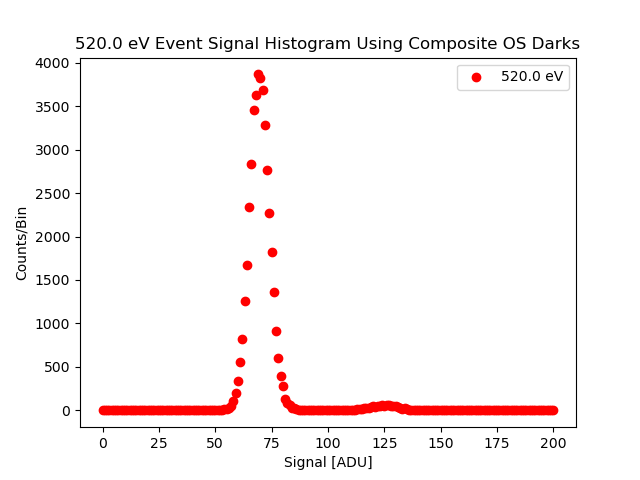

In [46]:
plt.figure('520.0 eV Event Signal Histogram 1')
plt.clf()
#plt.plot(BinsX_520,HistogramY_520, color = 'black', label = '490.5 eV')
plt.scatter(BinsX_520,HistogramY_520, color = 'red', label = '520.0 eV')
plt.title('520.0 eV Event Signal Histogram Using Composite OS Darks')
plt.xlabel('Signal [ADU]')
plt.ylabel('Counts/Bin')
plt.legend()
plt.show()

In [47]:
#now trying without the compositing using just CS darks
ROI = [10,DimX-10,10,310]
IntegrationRegionSize = 3
thres = 20
thresp = -1000000
IntegrationRegionSize = 5

filepattern = '*.FTS'
FileNamesList = glob2.glob(Directory3 + filepattern)
ImagesList = MakeImagesList(FileNamesList,1)

#CompositeDarkFrame = np.loadtxt(Directory2 + 'OS_ROI1CompositeMasterDarkFrame' +'.csv', delimiter=',')

AllEventSignals2, FrameMeanEventSignals2, AssociatedFileNames2 = ut.EventFinderSteveB(ImagesList,
                                                                                   ROI, MeanDarkFrame, HotsArray,
                                                                                   IntegrationRegionSize, thres,
                                                                                   thresp, verbose=False, diagonals=False)

  0%|          | 0/289 [00:00<?, ?it/s]

In [48]:
np.savetxt(Directory2 + 'AllEventSignalsROI1_CS_MeanDark2' +'.csv', AllEventSignals2, delimiter=',')

In [49]:
ToHistogramArray = np.loadtxt(Directory2 + 'AllEventSignalsROI1_CS_MeanDark2' +'.csv', delimiter=',')
MinX = 0
MaxX = 200
BinsPerUnitX = 1
HistogramY_520_CS, BinsX_520_CS = MakeHistogramSet(ToHistogramArray,MinX,MaxX,BinsPerUnitX,BinSize=False)

Only Valid if Integer: 200
Bin Size: 1.0


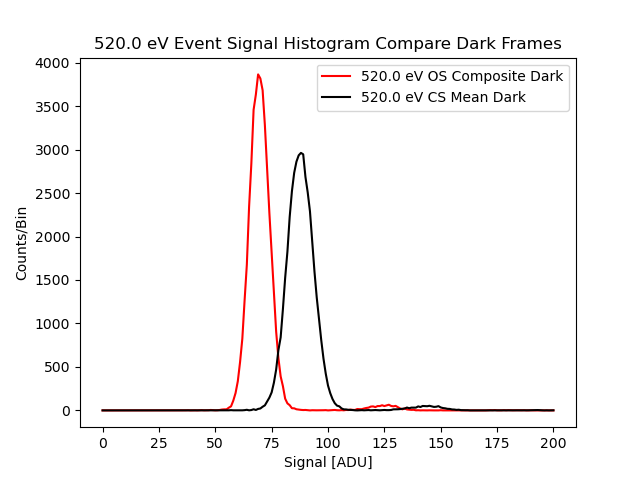

In [50]:
plt.figure('520.0 eV Event Signal Histogram compare 1')
plt.clf()
plt.plot(BinsX_520,HistogramY_520, color = 'red', label = '520.0 eV OS Composite Dark')
plt.plot(BinsX_520_CS,HistogramY_520_CS, color = 'black', label = '520.0 eV CS Mean Dark')
#plt.scatter(BinsX_520,HistogramY_520, color = 'red', label = '520.0 eV')
plt.title('520.0 eV Event Signal Histogram Compare Dark Frames')
plt.xlabel('Signal [ADU]')
plt.ylabel('Counts/Bin')
plt.legend()
plt.show()

[3893.09454253   57.74385179   69.51201975  124.73099081    4.37308367
    6.20657792]
[8.06169466 6.76685945 0.01045656 0.83989354 0.01045656 0.83989354]
[3006.01303706   48.85693086   87.67757154  143.5338744     5.66809505
    7.34194081]
[6.2156304  5.46152398 0.0135332  0.94759127 0.0135332  0.94759126]


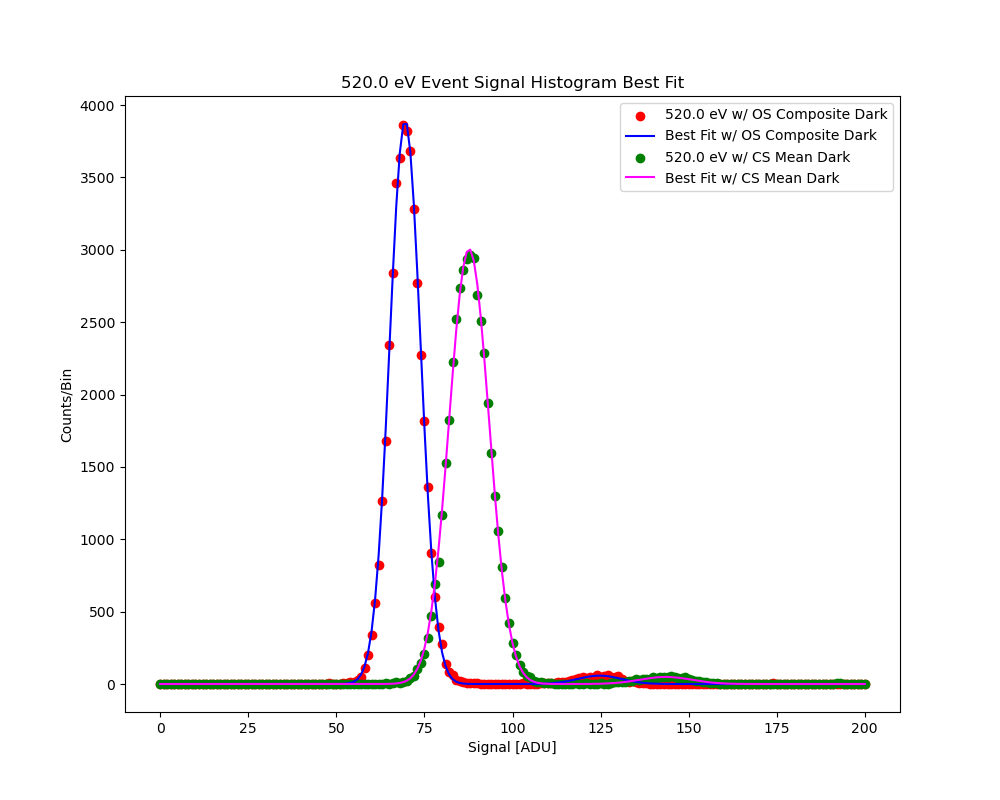

_________________________________
 Using the OS Composite Darks
 -----------------------------
 Centroid: 69.51
 Centroid Err: 0.01
 Standard Deviation: 4.37
 Standard Deviation Error: 0.01
_________________________________
 Using the CS Mean Darks
 -----------------------------
 Centroid: 87.68
 Centroid Err: 0.01
 Standard Deviation: 5.67
 Standard Deviation Error: 0.01


In [51]:
#Curve Fitting 
#[n1, n2, c1, c2, w1, w2, a, b, c]
test = [3800, 70, 68, 125, 1, 1]

xAxis = BinsX_520
yAxis = HistogramY_520

popt, pcov = curve_fit(doubleGauss, xAxis, yAxis, p0=test)
perr = np.sqrt(np.diag(pcov))
print(popt)
print(perr)

test2 = [3000, 70, 88, 144, 1, 1]

xAxis2 = BinsX_520_CS
yAxis2 = HistogramY_520_CS

popt2, pcov2 = curve_fit(doubleGauss, xAxis2, yAxis2, p0=test2)
perr2 = np.sqrt(np.diag(pcov2))
print(popt2)
print(perr2)

plt.figure(figsize=(10,8))
plt.clf()
#plt.statter(BinsX_520_CS,HistogramY_520_CS, color = 'black', label = '520.0 eV CS Mean Dark')

plt.scatter(BinsX_520,HistogramY_520, color = 'r', label = '520.0 eV w/ OS Composite Dark')
plt.plot(xAxis,doubleGauss(xAxis, *popt), color = 'b', label = 'Best Fit w/ OS Composite Dark')
plt.scatter(BinsX_520_CS,HistogramY_520_CS, color = 'green', label = '520.0 eV w/ CS Mean Dark')
plt.plot(xAxis2,doubleGauss(xAxis2, *popt2), color = 'magenta', label = 'Best Fit w/ CS Mean Dark')
#plt.scatter(BinsX_520,HistogramY_520, color = 'red', label = '520.0 eV')
plt.title('520.0 eV Event Signal Histogram Best Fit')
plt.xlabel('Signal [ADU]')
plt.ylabel('Counts/Bin')
plt.legend()
plt.show()

Centroid = popt[2]
CentroidErr = perr[2]
Sigma = popt[4]
SigmaErr = perr[4]

Centroid2 = popt2[2]
CentroidErr2 = perr2[2]
Sigma2 = popt2[4]
SigmaErr2 = perr2[4]

print("_________________________________")
print(" Using the OS Composite Darks")
print(" -----------------------------")
print(" Centroid: " + str(round(Centroid,2)))
print(" Centroid Err: " + str(round(CentroidErr,2)))
print(" Standard Deviation: " + str(round(Sigma,2)))
print(" Standard Deviation Error: " + str(round(SigmaErr,2)))

print("_________________________________")
print(" Using the CS Mean Darks")
print(" -----------------------------")
print(" Centroid: " + str(round(Centroid2,2)))
print(" Centroid Err: " + str(round(CentroidErr2,2)))
print(" Standard Deviation: " + str(round(Sigma2,2)))
print(" Standard Deviation Error: " + str(round(SigmaErr2,2)))

[ 3.89594538e+03  5.51965454e+01  6.94925313e+01  1.24809120e+02
  4.36465882e+00  5.76687840e+00 -5.00046251e-04  1.04351065e-01
 -2.01374509e+00]
[7.61231031e+00 6.68455804e+00 9.65173790e-03 7.83882926e-01
 1.02245259e-02 8.47841394e-01 4.62943394e-04 9.52506124e-02
 3.67795231e+00]
[ 3.00497253e+03  4.78929849e+01  8.76854984e+01  1.43569158e+02
  5.66708502e+00 -7.05204234e+00 -1.45498011e-04  3.95769728e-02
 -1.31167872e+00]
[6.44384808e+00 5.78470955e+00 1.35484187e-02 9.55277784e-01
 1.48844755e-02 1.04410244e+00 4.51139930e-04 9.43218831e-02
 3.55194472e+00]


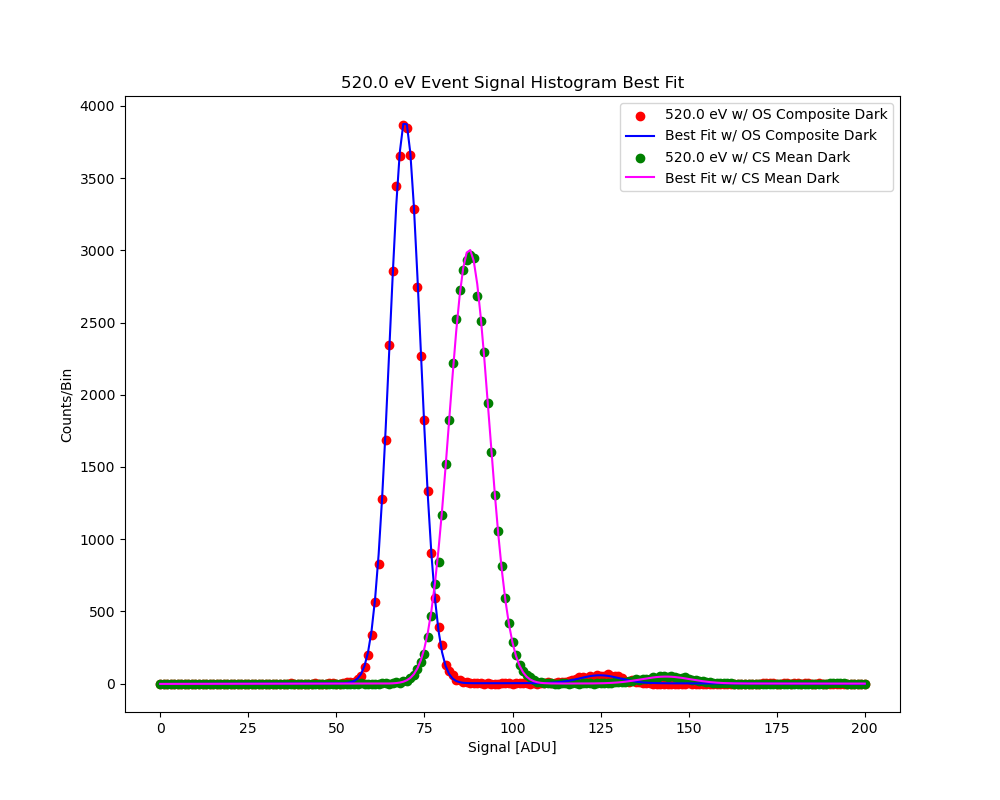

_________________________________
 Using the OS Composite Darks
 -----------------------------
 Centroid: 69.49
 Centroid Err: 0.01
 Standard Deviation: 4.36
 Standard Deviation Error: 0.01
_________________________________
 Using the CS Mean Darks
 -----------------------------
 Centroid: 87.69
 Centroid Err: 0.01
 Standard Deviation: 5.67
 Standard Deviation Error: 0.01


In [33]:
#Old 3x3 non-master hots Curve Fitting 
#[n1, n2, c1, c2, w1, w2, a, b, c]
test = [3800, 70, 68, 125, 1, 1]

xAxis = BinsX_520
yAxis = HistogramY_520

popt, pcov = curve_fit(doubleGauss, xAxis, yAxis, p0=test)
perr = np.sqrt(np.diag(pcov))
print(popt)
print(perr)

test2 = [3000, 70, 88, 144, 1, 1, 0, 0, 1]

xAxis2 = BinsX_520_CS
yAxis2 = HistogramY_520_CS

popt2, pcov2 = curve_fit(doubleGauss, xAxis2, yAxis2, p0=test2)
perr2 = np.sqrt(np.diag(pcov2))
print(popt2)
print(perr2)

plt.figure(figsize=(10,8))
plt.clf()
#plt.statter(BinsX_520_CS,HistogramY_520_CS, color = 'black', label = '520.0 eV CS Mean Dark')

plt.scatter(BinsX_520,HistogramY_520, color = 'r', label = '520.0 eV w/ OS Composite Dark')
plt.plot(xAxis,doubleGauss(xAxis, *popt), color = 'b', label = 'Best Fit w/ OS Composite Dark')
plt.scatter(BinsX_520_CS,HistogramY_520_CS, color = 'green', label = '520.0 eV w/ CS Mean Dark')
plt.plot(xAxis2,doubleGauss(xAxis2, *popt2), color = 'magenta', label = 'Best Fit w/ CS Mean Dark')
#plt.scatter(BinsX_520,HistogramY_520, color = 'red', label = '520.0 eV')
plt.title('520.0 eV Event Signal Histogram Best Fit')
plt.xlabel('Signal [ADU]')
plt.ylabel('Counts/Bin')
plt.legend()
plt.show()

Centroid = popt[2]
CentroidErr = perr[2]
Sigma = popt[4]
SigmaErr = perr[4]

Centroid2 = popt2[2]
CentroidErr2 = perr2[2]
Sigma2 = popt2[4]
SigmaErr2 = perr2[4]

print("_________________________________")
print(" Using the OS Composite Darks")
print(" -----------------------------")
print(" Centroid: " + str(round(Centroid,2)))
print(" Centroid Err: " + str(round(CentroidErr,2)))
print(" Standard Deviation: " + str(round(Sigma,2)))
print(" Standard Deviation Error: " + str(round(SigmaErr,2)))

print("_________________________________")
print(" Using the CS Mean Darks")
print(" -----------------------------")
print(" Centroid: " + str(round(Centroid2,2)))
print(" Centroid Err: " + str(round(CentroidErr2,2)))
print(" Standard Deviation: " + str(round(Sigma2,2)))
print(" Standard Deviation Error: " + str(round(SigmaErr2,2)))

***
### 981.0 eV

In [52]:
SetName = 'X0_YP2_981eV'

Directory1 = 'SteadyStateDataSets/Gain_Data/' + SetName + ForwardSlash 
Directory2 = 'SteadyStateDataSets/Gain_Data/' + SetName + '/CroppedROI1/'
Directory3 = Directory1 + "BeamImages/"
Directory4 = Directory2 + "BeamImages/"

In [7]:
DimY = 1096
DimX = 1936
hotsig = 5.0 #Number of stdevs above a frame's median a pixel must be to be considered hot.
hotfrac = 0.1 #The fraction of the frames in a given set a certain pixel must be hot in order to be recorded as hot in the HotsArray

DarkFrameName = 'MeanCS_Dark'
HotsArrayName = 'MasterHotsArray'

SetName = 'X0_YP2_981eV'
datadirectory = 'SteadyStateDataSets/Gain_Data/' + SetName +"/CS_Darks/"
filepattern = '*.FTS'

SaveDirectory = 'SteadyStateDataSets/Gain_Data/' + SetName + ForwardSlash 

MeanDarkFrame, HotsArray = ut.ReturnMasterDarkAndHotsArray(datadirectory,filepattern,DimX,DimY,hotsig,hotfrac)


np.savetxt(SaveDirectory + DarkFrameName +'.csv', MeanDarkFrame, delimiter=',')
np.savetxt(SaveDirectory + HotsArrayName +'.csv', HotsArray, delimiter=',')

  0%|          | 0/44 [00:00<?, ?it/s]

C:\Users\Colin Packard\PythonWorkspace\Argonne12_01\Utility3_4.py:234: RuntimeWarning: invalid value encountered in sqrt
  StdDarkFrame = np.sqrt((SumDarkSquared/len(ImagesList)) - MeanDarkFrame**2)


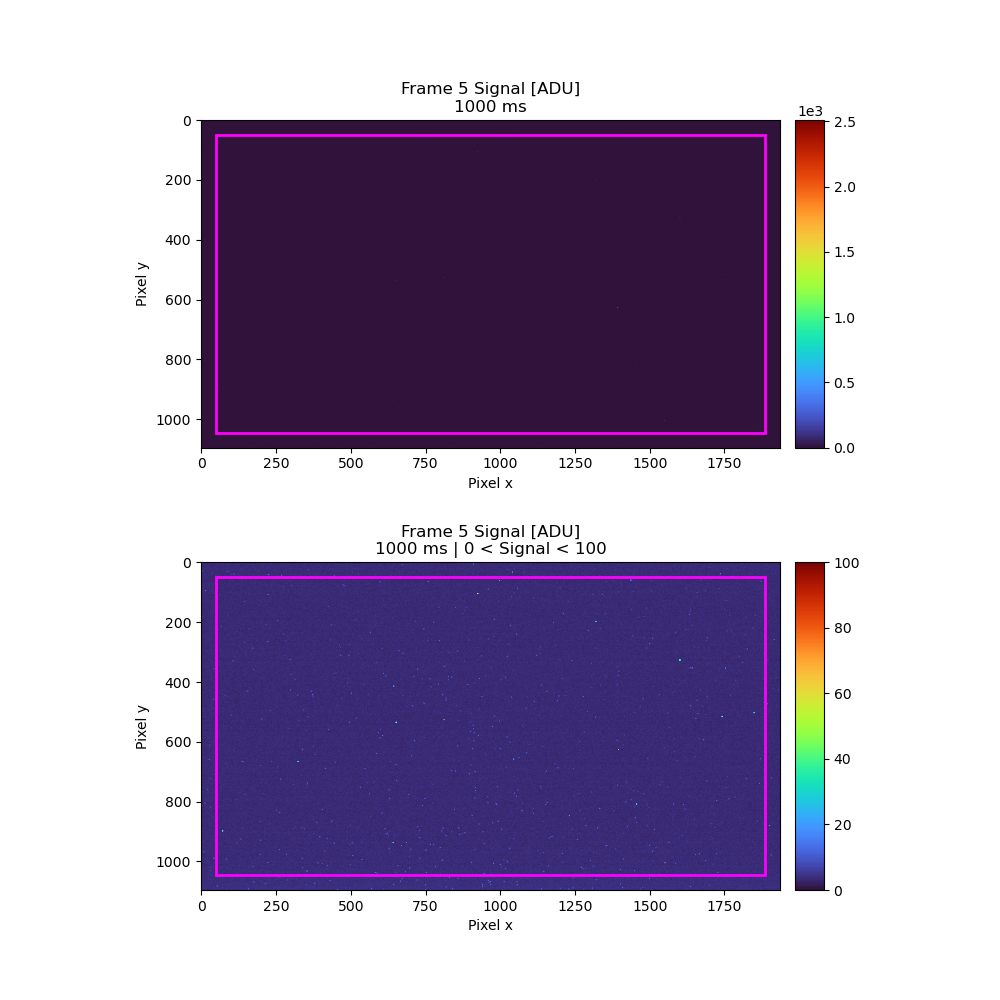

In [53]:
#Pick an ROI 
#ROI = [x0,x1,y0,y1]
ROI = [50,DimX-50,50,DimY-50]
#I can use the whole frame as an ROI in this case but reuse the ROI code for copy paste simplicity.
#Draw the ROI to be sure
xROI, yROI = ROItoPoints(ROI)

#X0_YP2_981eV
filepattern = '*.FTS'
FileNamesList = glob2.glob(Directory3 + filepattern)

#Grab Darks and Hots
DarkFrameName = 'MeanCS_Dark'
HotsArrayName = 'MasterHotsArray'
MeanDarkFrame = np.loadtxt(Directory1 + DarkFrameName + '.csv', delimiter=',')
HotsArray = np.loadtxt(Directory1 + HotsArrayName + '.csv', delimiter=',')

#Grab The 5th image in the set
ReducedFileNamesList = [FileNamesList[4],FileNamesList[5]]
ReducedImagesList = ut.MakeImagesList(ReducedFileNamesList,1)
image_and_metadata = ReducedImagesList[0]
FifthImage = image_and_metadata[0]

f, ax = plt.subplots(2, 1)
im1 = ax[0].imshow(FifthImage, cmap='turbo')
divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes("right", size="5%", pad=0.15)
cbar1 = plt.colorbar(im1, cax=cax1)
cbar1.formatter.set_powerlimits((0, 0))
#cbar1.formatter.set_useMathText(True)
ax[0].fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=2, label = "ROI")
ax[0].set_xlabel('Pixel x')
ax[0].set_ylabel('Pixel y')
#ax[0].set_title('Sum of Dark Subtracted Frames [e$^-$] | CrSc 551.2 eV 300 ms')
ax[0].set_title(r"Frame 5 Signal [ADU]"
               "\n" r"1000 ms", loc = 'center')

im2 = ax[1].imshow(FifthImage, cmap='turbo',vmin = 0, vmax = 100)
divider = make_axes_locatable(ax[1])
cax2 = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im2, cax=cax2)
#cbar2 = plt.colorbar(im2, cax=cax2)
#cbar2.formatter.set_powerlimits((0, 0))
ax[1].fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=2, label = "ROI")
ax[1].set_xlabel('Pixel x')
ax[1].set_ylabel('Pixel y')
ax[1].set_title(r"Frame 5 Signal [ADU]"
               "\n" r"1000 ms | 0 < Signal < 100", loc = 'center')

plt.subplots_adjust(hspace = 0.35)

figure = plt.gcf()

figure.set_size_inches(10, 10)

plt.show()

In [15]:
#Grab darks and hots, and make a cropped image list.
DarkFrameName = 'MeanCS_Dark'
HotsArrayName = 'MasterHotsArray'
MeanDarkFrame = np.loadtxt(Directory1 + DarkFrameName + '.csv', delimiter=',')
HotsArray = np.loadtxt(Directory1 + HotsArrayName + '.csv', delimiter=',')

filepattern = '*.FTS'
FileNamesList = glob2.glob(Directory3 + filepattern)

CroppedImagesList = MakeCroppedImagesList(FileNamesList,ROI,1)

CroppedHotsArray = HotsArray[ROI[2]:ROI[3],ROI[0]:ROI[1]]
CroppedPrelimMeanDarkArray = MeanDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]]

print(np.shape(CroppedPrelimMeanDarkArray))

(996, 1836)


In [17]:
CroppedDimX = 1836
CroppedDimY = 996
IntegrationRegionSize = 5
thres = 20

OS_ROI1MasterDarkFrame, N_Array, SampleStdFrame, StandardErrorOfMeanFrame, SumDarkArray, DivideByArray = ut.MakeMasterIlluminatedDarkFrameStandard(CroppedImagesList,
                                                                CroppedPrelimMeanDarkArray,CroppedHotsArray,CroppedDimX,
                                                                CroppedDimY,IntegrationRegionSize,thres)

np.savetxt(Directory2 + 'OS_ROI1MasterDarkFrame4' +'.csv', OS_ROI1MasterDarkFrame, delimiter=',')

  0%|          | 0/298 [00:00<?, ?it/s]

In [54]:
DarkFrameName = 'MeanCS_Dark'
MeanDarkFrame = np.loadtxt(Directory1 + DarkFrameName + '.csv', delimiter=',')
OS_ROI1MasterDarkFrame3 = np.loadtxt(Directory2 + 'OS_ROI1MasterDarkFrame4' +'.csv', delimiter=',')

print("----------------------------------------------------------------------------------")
print("OS_ROI_MasterDark")
print(OS_ROI1MasterDarkFrame3)
print("CS_ROI_MasterDark")
ROI_MeanDarkForTest = MeanDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]]
print(ROI_MeanDarkForTest)

CompositeDarkFrame = np.zeros(np.shape(MeanDarkFrame))
CompositeDarkFrame = np.where(CompositeDarkFrame == 0, MeanDarkFrame, CompositeDarkFrame)
CompositeDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]] = OS_ROI1MasterDarkFrame3

print("CompositeDarkFrame")
print(CompositeDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]])
ROI_MeanDarkForTest = MeanDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]]
print("CS_ROI_MasterDark_Again")
print(ROI_MeanDarkForTest)

print("Mean Signal CS_Dark")
print(np.mean(MeanDarkFrame))
print("MeanSignal OS_Dark Composite")
print(np.mean(CompositeDarkFrame))

----------------------------------------------------------------------------------
OS_ROI_MasterDark
[[3.4966443  3.44630872 3.47651007 ... 3.68013468 3.04713805 3.50841751]
 [3.23825503 3.37248322 3.5738255  ... 3.76351351 3.43918919 3.5       ]
 [3.4966443  3.36241611 3.2885906  ... 3.44256757 3.15540541 3.57432432]
 ...
 [3.82550336 4.13468013 3.80808081 ... 3.62289562 3.70469799 3.53020134]
 [3.97315436 3.78114478 4.13468013 ... 3.44444444 3.83221477 4.43288591]
 [3.91610738 3.75167785 3.53355705 ... 3.51677852 3.7852349  3.44966443]]
CS_ROI_MasterDark
[[3.34090909 3.63636364 3.43181818 ... 3.54545455 3.04545455 3.63636364]
 [3.45454545 3.54545455 3.61363636 ... 3.72727273 3.75       3.31818182]
 [3.36363636 3.34090909 3.27272727 ... 3.5        3.06818182 3.38636364]
 ...
 [3.97727273 4.43181818 4.02272727 ... 3.20454545 3.72727273 3.47727273]
 [4.13636364 3.86363636 3.79545455 ... 3.56818182 3.75       3.84090909]
 [3.97727273 4.02272727 3.43181818 ... 3.54545455 3.75       3.4318

In [55]:
#Making and saving composite dark frame
DarkFrameName = 'MeanCS_Dark'
MeanDarkFrame = np.loadtxt(Directory1 + DarkFrameName + '.csv', delimiter=',')
OS_ROI1MasterDarkFrame3 = np.loadtxt(Directory2 + 'OS_ROI1MasterDarkFrame4' +'.csv', delimiter=',')

CompositeDarkFrame = np.zeros(np.shape(MeanDarkFrame))
CompositeDarkFrame = np.where(CompositeDarkFrame == 0, MeanDarkFrame, CompositeDarkFrame)
CompositeDarkFrame[ROI[2]:ROI[3],ROI[0]:ROI[1]] = OS_ROI1MasterDarkFrame3

np.savetxt(Directory2 + 'OS_ROI1CompositeMasterDarkFrame2' +'.csv', CompositeDarkFrame, delimiter=',')

In [56]:
ROI = [50,DimX-50,50,DimY-50]
#IntegrationRegionSize = 3
thres = 20
thresp = -1000000
#thres = 30
#thresp = 3
IntegrationRegionSize = 5

filepattern = '*.FTS'
FileNamesList = glob2.glob(Directory3 + filepattern)
ImagesList = MakeImagesList(FileNamesList,1)

CompositeDarkFrame = np.loadtxt(Directory2 + 'OS_ROI1CompositeMasterDarkFrame2' +'.csv', delimiter=',')

AllEventSignals, FrameMeanEventSignals, AssociatedFileNames = ut.EventFinderSteveB(ImagesList,
                                                                                   ROI, CompositeDarkFrame, HotsArray,
                                                                                   IntegrationRegionSize, thres,
                                                                                   thresp, verbose=False, diagonals=False)

  0%|          | 0/298 [00:00<?, ?it/s]

In [57]:
np.savetxt(Directory2 + 'AllEventSignalsROI1_OS_CompositeDark2' +'.csv', AllEventSignals, delimiter=',')

In [67]:
ROI = [50,DimX-50,50,DimY-50]
#IntegrationRegionSize = 3
#thres = 20
#thresp = -1000000
thres = 30
thresp = 3
IntegrationRegionSize = 5

filepattern = '*.FTS'
FileNamesList = glob2.glob(Directory3 + filepattern)
ImagesList = MakeImagesList(FileNamesList,1)

CompositeDarkFrame = np.loadtxt(Directory2 + 'OS_ROI1CompositeMasterDarkFrame2' +'.csv', delimiter=',')

AllEventSignals, FrameMeanEventSignals, AssociatedFileNames = ut.EventFinderSteveB(ImagesList,
                                                                                   ROI, CompositeDarkFrame, HotsArray,
                                                                                   IntegrationRegionSize, thres,
                                                                                   thresp, verbose=False, diagonals=False)

  0%|          | 0/298 [00:00<?, ?it/s]

In [68]:
np.savetxt(Directory2 + 'AllEventSignalsROI1_OS_CompositeDarkThres30Thresp3' +'.csv', AllEventSignals, delimiter=',')

In [69]:
AllEventSignalsThresThresp = np.loadtxt(Directory2 + 'AllEventSignalsROI1_OS_CompositeDarkThres30Thresp3' +'.csv', delimiter=',')
ToHistogramArray = AllEventSignalsThresThresp
MinX = 0
MaxX = 200
BinsPerUnitX = 1
HistogramY_981ThresThresp, BinsX_981ThresThresp = MakeHistogramSet(ToHistogramArray,MinX,MaxX,BinsPerUnitX,BinSize=False)

Only Valid if Integer: 200
Bin Size: 1.0


In [70]:
AllEventSignals = np.loadtxt(Directory2 + 'AllEventSignalsROI1_OS_CompositeDark2' +'.csv', delimiter=',')
ToHistogramArray = AllEventSignals
MinX = 0
MaxX = 200
BinsPerUnitX = 1
HistogramY_981, BinsX_981 = MakeHistogramSet(ToHistogramArray,MinX,MaxX,BinsPerUnitX,BinSize=False)

Only Valid if Integer: 200
Bin Size: 1.0


In [71]:
AllEventSignalsOld = np.loadtxt(Directory2 + 'AllEventSignalsROI1_OS_CompositeDark' +'.csv', delimiter=',')
ToHistogramArray = AllEventSignalsOld
MinX = 0
MaxX = 200
BinsPerUnitX = 1
HistogramY_981_Old, BinsX_981_Old = MakeHistogramSet(ToHistogramArray,MinX,MaxX,BinsPerUnitX,BinSize=False)

Only Valid if Integer: 200
Bin Size: 1.0


C:\Users\Colin Packard\AppData\Local\Temp\ipykernel_8032\3045106127.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,5))


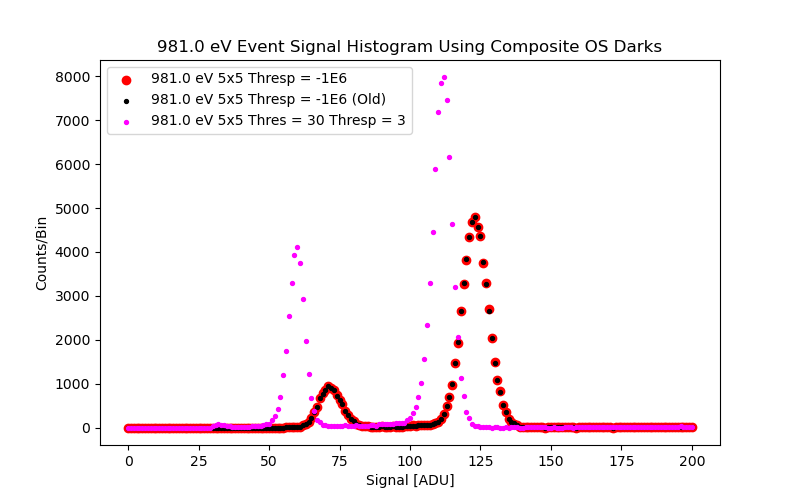

In [75]:
plt.figure(figsize=(8,5))
plt.clf()
plt.scatter(BinsX_981,HistogramY_981, color = 'red', label = '981.0 eV 5x5 Thresp = -1E6')
plt.scatter(BinsX_981_Old,HistogramY_981_Old, color = 'black',s=8, label = '981.0 eV 5x5 Thresp = -1E6 (Old)')
plt.scatter(BinsX_981ThresThresp,HistogramY_981ThresThresp, color = 'magenta',s=8, label = '981.0 eV 5x5 Thres = 30 Thresp = 3')
plt.title('981.0 eV Event Signal Histogram Using Composite OS Darks')
plt.xlabel('Signal [ADU]')
plt.ylabel('Counts/Bin')
plt.legend()
plt.show()

In [76]:
#now trying without the compositing using just CS darks
ROI = [50,DimX-50,50,DimY-50]
IntegrationRegionSize = 3
thres = 20
thresp = -1000000
IntegrationRegionSize = 3

filepattern = '*.FTS'
FileNamesList = glob2.glob(Directory3 + filepattern)
ImagesList = MakeImagesList(FileNamesList,1)

CompositeDarkFrame = np.loadtxt(Directory2 + 'OS_ROI1CompositeMasterDarkFrame2' +'.csv', delimiter=',')

AllEventSignals2, FrameMeanEventSignals2, AssociatedFileNames2 = ut.EventFinderSteveB(ImagesList,
                                                                                   ROI, MeanDarkFrame, HotsArray,
                                                                                   IntegrationRegionSize, thres,
                                                                                   thresp, verbose=False, diagonals=False)

  0%|          | 0/298 [00:00<?, ?it/s]

In [77]:
np.savetxt(Directory2 + 'AllEventSignalsROI1_CS_MeanDark2' +'.csv', AllEventSignals2, delimiter=',')

In [78]:
ToHistogramArray = np.loadtxt(Directory2 + 'AllEventSignalsROI1_CS_MeanDark2' +'.csv', delimiter=',')
MinX = 0
MaxX = 200
BinsPerUnitX = 1
HistogramY_981_CS, BinsX_981_CS = MakeHistogramSet(ToHistogramArray,MinX,MaxX,BinsPerUnitX,BinSize=False)

Only Valid if Integer: 200
Bin Size: 1.0


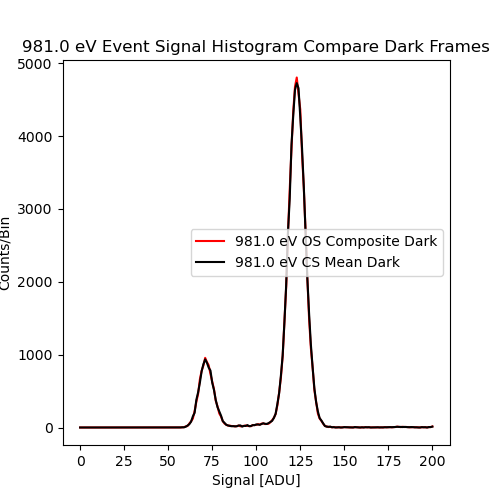

In [79]:
plt.figure(figsize=(5,5))
plt.clf()
plt.plot(BinsX_981,HistogramY_981, color = 'red', label = '981.0 eV OS Composite Dark')
plt.plot(BinsX_981_CS,HistogramY_981_CS, color = 'black', label = '981.0 eV CS Mean Dark')
plt.title('981.0 eV Event Signal Histogram Compare Dark Frames')
plt.xlabel('Signal [ADU]')
plt.ylabel('Counts/Bin')
plt.legend()
plt.show()

[4.74391341e+03 9.21188526e+02 1.23038863e+02 7.15954132e+01
 4.62764427e+00 4.07212549e+00]
[10.25246564 10.92944009  0.01154839  0.05578786  0.01154839  0.05578786]
[4.71320075e+03 9.10935796e+02 1.23071112e+02 7.16178013e+01
 4.66759419e+00 4.12953952e+00]
[ 9.85192032 10.47410153  0.01126595  0.05482768  0.01126595  0.05482768]


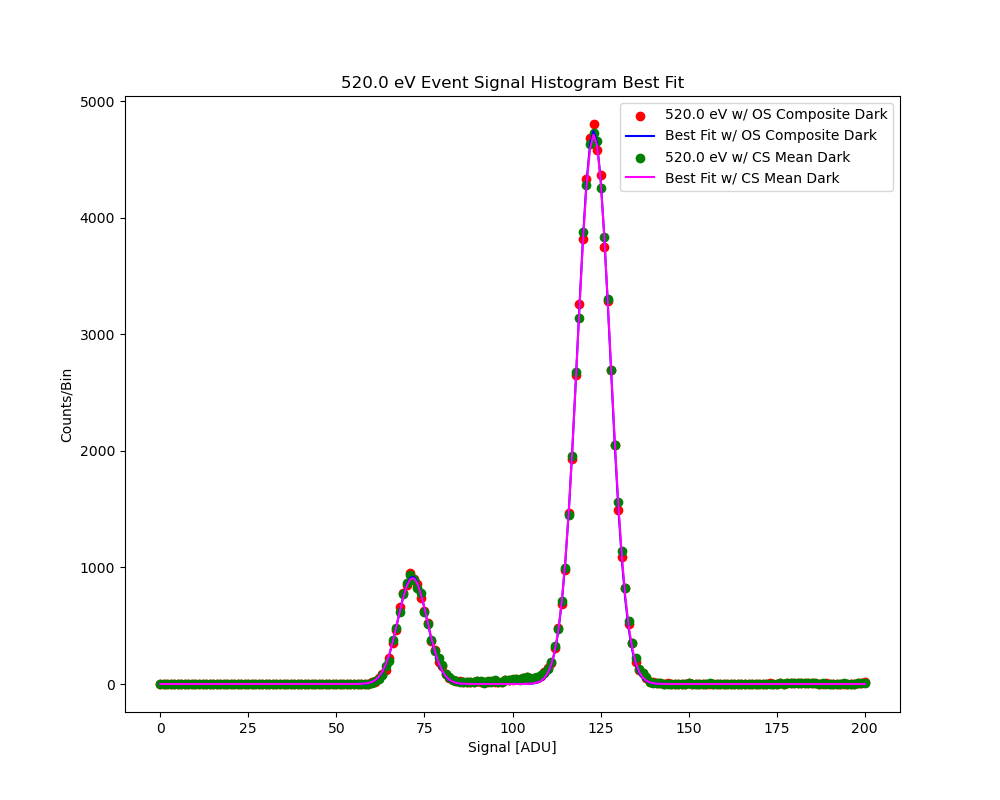

_________________________________
 Using the OS Composite Darks
 -----------------------------
 Centroid: 123.04
 Centroid Err: 0.01
 Standard Deviation: 4.63
 Standard Deviation Error: 0.01
_________________________________
 Using the CS Mean Darks
 -----------------------------
 Centroid: 123.07
 Centroid Err: 0.01
 Standard Deviation: 4.67
 Standard Deviation Error: 0.01
_________________________________
 Secondary Peak Using the OS Composite Darks
 -----------------------------
 Centroid: 71.62
 Centroid Err: 0.05
 Standard Deviation: 4.13
 Standard Deviation Error: 0.05


In [82]:
#Curve Fitting 
#[n1, n2, c1, c2, w1, w2]
test = [4750, 930, 125, 72, 1, 1]

xAxis = BinsX_981
yAxis = HistogramY_981

popt, pcov = curve_fit(doubleGauss, xAxis, yAxis, p0=test)
perr = np.sqrt(np.diag(pcov))
print(popt)
print(perr)

test2 = [4750, 930, 125, 72, 1, 1]

xAxis2 = BinsX_981_CS
yAxis2 = HistogramY_981_CS

popt2, pcov2 = curve_fit(doubleGauss, xAxis2, yAxis2, p0=test2)
perr2 = np.sqrt(np.diag(pcov2))
print(popt2)
print(perr2)

plt.figure(figsize=(10,8))
plt.clf()
#plt.statter(BinsX_520_CS,HistogramY_520_CS, color = 'black', label = '520.0 eV CS Mean Dark')

plt.scatter(BinsX_981,HistogramY_981, color = 'r', label = '520.0 eV w/ OS Composite Dark')
plt.plot(xAxis,doubleGauss(xAxis, *popt), color = 'b', label = 'Best Fit w/ OS Composite Dark')
plt.scatter(BinsX_981_CS,HistogramY_981_CS, color = 'green', label = '520.0 eV w/ CS Mean Dark')
plt.plot(xAxis2,doubleGauss(xAxis2, *popt2), color = 'magenta', label = 'Best Fit w/ CS Mean Dark')
#plt.scatter(BinsX_520,HistogramY_520, color = 'red', label = '520.0 eV')
plt.title('520.0 eV Event Signal Histogram Best Fit')
plt.xlabel('Signal [ADU]')
plt.ylabel('Counts/Bin')
plt.legend()
plt.show()

Centroid = popt[2]
CentroidErr = perr[2]
Sigma = popt[4]
SigmaErr = perr[4]

Centroid2 = popt2[2]
CentroidErr2 = perr2[2]
Sigma2 = popt2[4]
SigmaErr2 = perr2[4]

Centroid3 = popt2[3]
CentroidErr3 = perr2[3]
Sigma3 = popt2[5]
SigmaErr3 = perr2[5]

print("_________________________________")
print(" Using the OS Composite Darks")
print(" -----------------------------")
print(" Centroid: " + str(round(Centroid,2)))
print(" Centroid Err: " + str(round(CentroidErr,2)))
print(" Standard Deviation: " + str(round(Sigma,2)))
print(" Standard Deviation Error: " + str(round(SigmaErr,2)))

print("_________________________________")
print(" Using the CS Mean Darks")
print(" -----------------------------")
print(" Centroid: " + str(round(Centroid2,2)))
print(" Centroid Err: " + str(round(CentroidErr2,2)))
print(" Standard Deviation: " + str(round(Sigma2,2)))
print(" Standard Deviation Error: " + str(round(SigmaErr2,2)))

print("_________________________________")
print(" Secondary Peak Using the OS Composite Darks")
print(" -----------------------------")
print(" Centroid: " + str(round(Centroid3,2)))
print(" Centroid Err: " + str(round(CentroidErr3,2)))
print(" Standard Deviation: " + str(round(Sigma3,2)))
print(" Standard Deviation Error: " + str(round(SigmaErr3,2)))

***
## Gain Determination 

In [6]:
#Load in Events 
SetName_490p5 = 'XM2_YP1_490p5eV'
SetName_520 = 'X0_Y0_520eV'
SetName_981 = 'X0_YP2_981eV'

Directory2_490p5 = 'SteadyStateDataSets/Gain_Data/' + SetName_490p5 + '/CroppedROI1/'
Directory2_520 = 'SteadyStateDataSets/Gain_Data/' + SetName_520 + '/CroppedROI1/'
Directory2_981 = 'SteadyStateDataSets/Gain_Data/' + SetName_981 + '/CroppedROI1/'

AllEventSignals = np.loadtxt(Directory2_490p5 + 'AllEventSignalsROI1_OS_CompositeDark2' +'.csv', delimiter=',')
ToHistogramArray = AllEventSignals
MinX = 0
MaxX = 200
BinsPerUnitX = 1
HistogramY_490p5, BinsX_490p5 = MakeHistogramSet(ToHistogramArray,MinX,MaxX,BinsPerUnitX,BinSize=False)

AllEventSignals = np.loadtxt(Directory2_520 + 'AllEventSignalsROI1_OS_CompositeDark2' +'.csv', delimiter=',')
ToHistogramArray = AllEventSignals
MinX = 0
MaxX = 200
BinsPerUnitX = 1
HistogramY_520, BinsX_520 = MakeHistogramSet(ToHistogramArray,MinX,MaxX,BinsPerUnitX,BinSize=False)

AllEventSignals = np.loadtxt(Directory2_981 + 'AllEventSignalsROI1_OS_CompositeDark2' +'.csv', delimiter=',')
ToHistogramArray = AllEventSignals
MinX = 0
MaxX = 200
BinsPerUnitX = 1
HistogramY_981, BinsX_981 = MakeHistogramSet(ToHistogramArray,MinX,MaxX,BinsPerUnitX,BinSize=False)

Only Valid if Integer: 200
Bin Size: 1.0
Only Valid if Integer: 200
Bin Size: 1.0
Only Valid if Integer: 200
Bin Size: 1.0


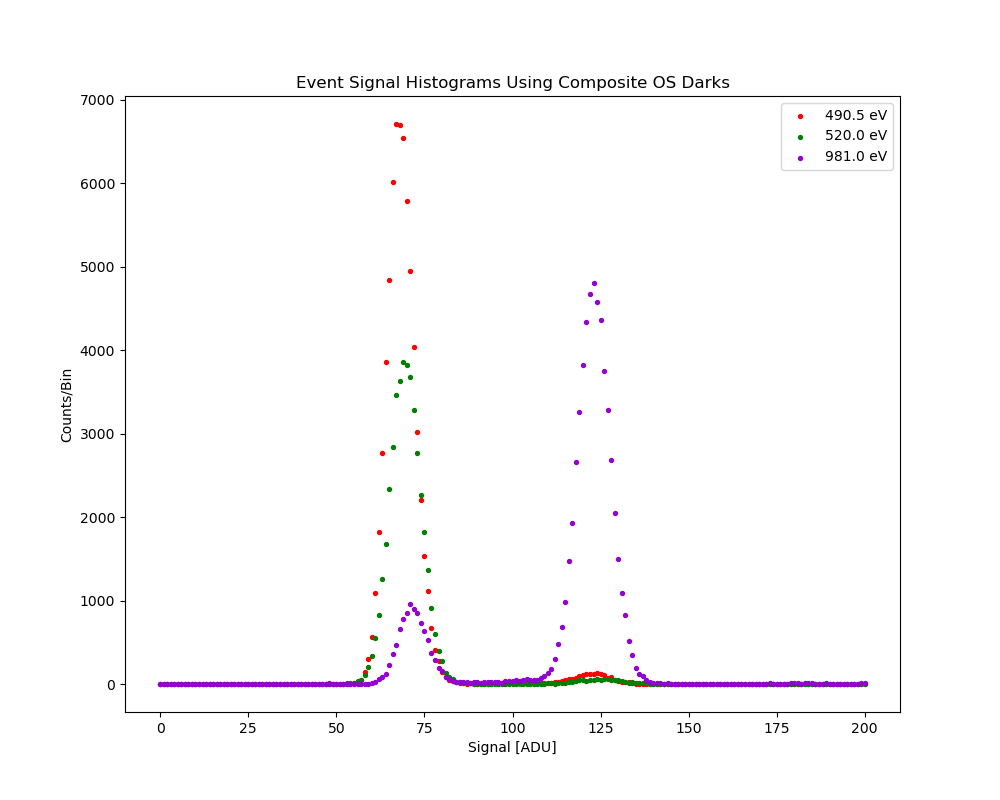

In [7]:
plt.figure(figsize=(10,8))
plt.clf()
plt.scatter(BinsX_490p5,HistogramY_490p5, color = 'red',s=8 , label = '490.5 eV')
plt.scatter(BinsX_520,HistogramY_520, color = 'green',s=8 , label = '520.0 eV')
plt.scatter(BinsX_981,HistogramY_981, color = 'darkviolet',s=8 , label = '981.0 eV')
plt.title('Event Signal Histograms Using Composite OS Darks')
plt.xlabel('Signal [ADU]')
plt.ylabel('Counts/Bin')
plt.legend()
plt.show()

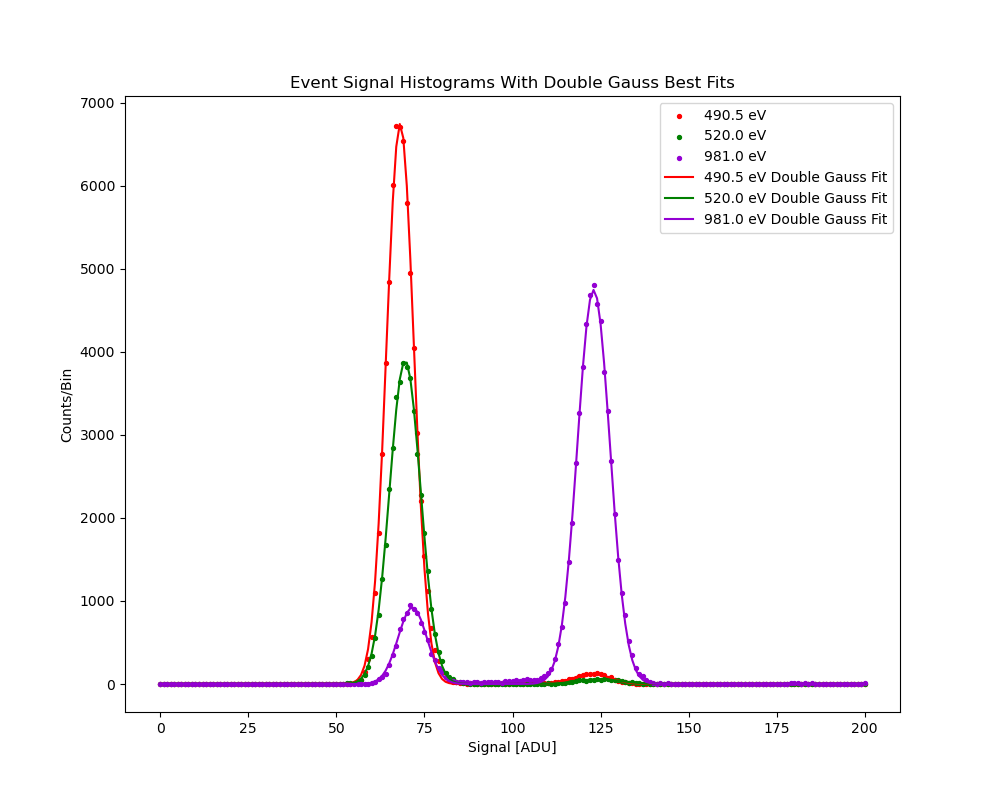

In [8]:
#Curve Fitting

CentroidsADU = []
CentroidsErrADU = []
SigmaADU = []
SigmaErrADU = []
Energies = []

wf = 3.64

#490.5 eV
Energy = 490.5
test = [6700, 150, 68, 122, 1, 1] #[n1, n2, c1, c2, w1, w2]

#xAxis = np.zeros(np.shape(BinsX_490p5))
#yAxis = np.zeros(np.shape(HistogramY_490p5))
xAxis = BinsX_490p5
yAxis = HistogramY_490p5

popt, pcov = curve_fit(doubleGauss, xAxis, yAxis, p0=test)
perr = np.sqrt(np.diag(pcov))

Centroid = popt[2]
CentroidErr = perr[2]
Sigma = popt[4]
SigmaErr = perr[4]

CentroidsADU.append(Centroid)
CentroidsErrADU.append(CentroidErr)
SigmaADU.append(Sigma)
SigmaErrADU.append(SigmaErr)
Energies.append(Energy)

xAxis_490p5 = BinsX_490p5
yAxis_490p5 = HistogramY_490p5
Fit_yAxis_490p5 = doubleGauss(xAxis_490p5, *popt)

#520.0 eV
Energy = 520.0
test = [3800, 70, 68, 125, 1, 1] #[n1, n2, c1, c2, w1, w2]

#xAxis = np.zeros(np.shape(BinsX_520))
#yAxis = np.zeros(np.shape(HistogramY_520))
xAxis = BinsX_520
yAxis = HistogramY_520

popt, pcov = curve_fit(doubleGauss, xAxis, yAxis, p0=test)
perr = np.sqrt(np.diag(pcov))

Centroid = popt[2]
CentroidErr = perr[2]
Sigma = popt[4]
SigmaErr = perr[4]

CentroidsADU.append(Centroid)
CentroidsErrADU.append(CentroidErr)
SigmaADU.append(Sigma)
SigmaErrADU.append(SigmaErr)
Energies.append(Energy)

xAxis_520 = BinsX_520
yAxis_520 = HistogramY_520
Fit_yAxis_520 = doubleGauss(xAxis_520, *popt)

#981 eV
Energy = 981.0
test = [4750, 930, 125, 72, 1, 1] #[n1, n2, c1, c2, w1, w2]

#xAxis = np.zeros(np.shape(BinsX_981))
#yAxis = np.zeros(np.shape(HistogramY_981))
xAxis = BinsX_981
yAxis = HistogramY_981

popt, pcov = curve_fit(doubleGauss, xAxis, yAxis, p0=test)
perr = np.sqrt(np.diag(pcov))

Centroid = popt[2]
CentroidErr = perr[2]
Sigma = popt[4]
SigmaErr = perr[4]

CentroidsADU.append(Centroid)
CentroidsErrADU.append(CentroidErr)
SigmaADU.append(Sigma)
SigmaErrADU.append(SigmaErr)
Energies.append(Energy)

xAxis_981 = BinsX_981
yAxis_981 = HistogramY_981
Fit_yAxis_981 = doubleGauss(xAxis_981, *popt)

CentroidsADU = np.array(CentroidsADU)
CentroidsErrADU = np.array(CentroidsErrADU)
SigmaADU = np.array(SigmaADU)
SigmaErrADU = np.array(SigmaErrADU)
Energies = np.array(Energies)
#-----------------

plt.figure(figsize=(10,8))
plt.clf()
plt.scatter(xAxis_490p5,yAxis_490p5, color = 'red',s=8 , label = '490.5 eV')
plt.scatter(xAxis_520,yAxis_520, color = 'green',s=8 , label = '520.0 eV')
plt.scatter(xAxis_981,yAxis_981, color = 'darkviolet',s=8 , label = '981.0 eV')

plt.plot(xAxis_490p5,Fit_yAxis_490p5, color = 'red' , label = '490.5 eV Double Gauss Fit')
plt.plot(xAxis_520,Fit_yAxis_520, color = 'green' , label = '520.0 eV Double Gauss Fit')
plt.plot(xAxis_981,Fit_yAxis_981, color = 'darkviolet' , label = '981.0 eV Double Gauss Fit')

plt.title('Event Signal Histograms With Double Gauss Best Fits')
plt.xlabel('Signal [ADU]')
plt.ylabel('Counts/Bin')
plt.legend()
plt.show()

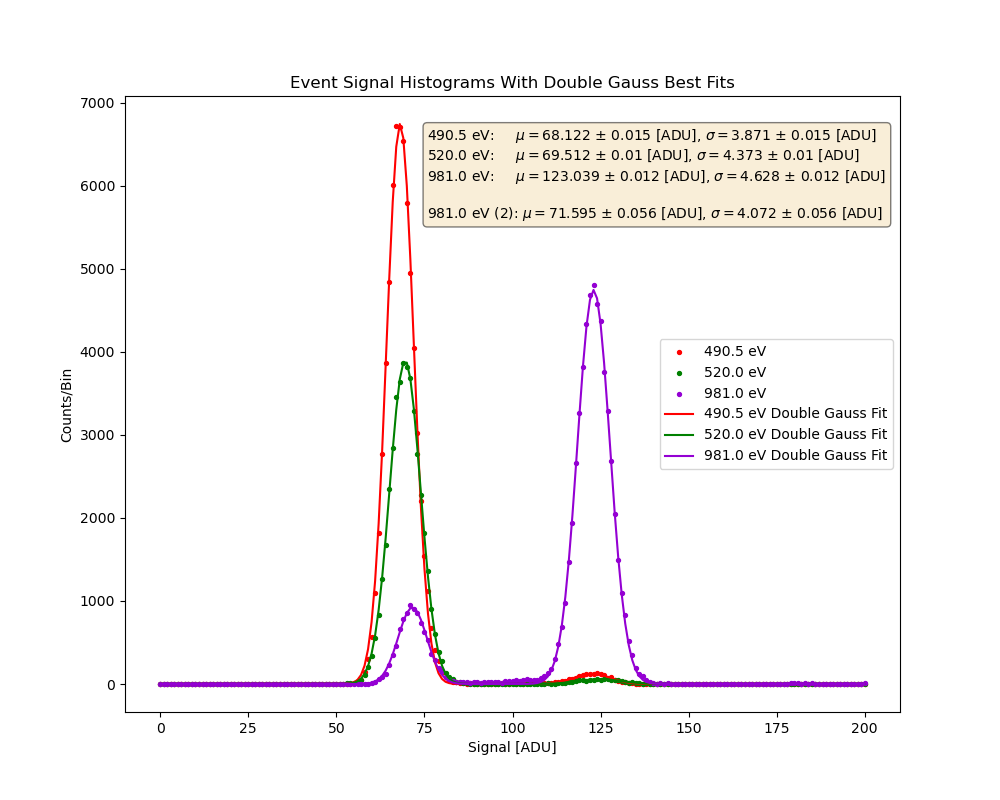

490.5 eV:     $\mu = $68.122 $\pm$ 0.015 [ADU], $\sigma = $3.871 $\pm$ 0.015 [ADU]
520.0 eV:     $\mu = $69.512 $\pm$ 0.01 [ADU], $\sigma = $4.373 $\pm$ 0.01 [ADU]
981.0 eV:     $\mu = $123.039 $\pm$ 0.012 [ADU], $\sigma = $4.628 $\pm$ 0.012 [ADU]
 
981.0 eV (2): $\mu = $71.595 $\pm$ 0.056 [ADU], $\sigma = $4.072 $\pm$ 0.056 [ADU]


In [9]:
Mu490p5 = str(round(CentroidsADU[0],3))
ErrMu490p5 = str(round(CentroidsErrADU[0],3))
Sigma490p5 = str(round(SigmaADU[0],3))
ErrSigma490p5 = str(round(SigmaErrADU[0],3))

Mu520 = str(round(CentroidsADU[1],3))
ErrMu520 = str(round(CentroidsErrADU[1],3))
Sigma520 = str(round(SigmaADU[1],3))
ErrSigma520 = str(round(SigmaErrADU[1],3))

Mu981 = str(round(CentroidsADU[2],3))
ErrMu981 = str(round(CentroidsErrADU[2],3))
Sigma981 = str(round(SigmaADU[2],3))
ErrSigma981 = str(round(SigmaErrADU[2],3))

Centroid = popt[3]
CentroidErr = perr[3]
Sigma = popt[5]
SigmaErr = perr[5]

Mu981u = str(round(Centroid,3))
ErrMu981u = str(round(CentroidErr,3))
Sigma981u = str(round(Sigma,3))
ErrSigma981u = str(round(SigmaErr,3))

textstr = '\n'.join((
    r'490.5 eV:     $\mu = $' + Mu490p5 + " $\pm$ " + ErrMu490p5 + " [ADU], " + "$\sigma = $" + Sigma490p5+ " $\pm$ " + ErrSigma490p5 + " [ADU]",
    r'520.0 eV:     $\mu = $' + Mu520 + " $\pm$ " + ErrMu520 + " [ADU], " + "$\sigma = $" + Sigma520+ " $\pm$ " + ErrSigma520 + " [ADU]",
    r'981.0 eV:     $\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " [ADU], " + "$\sigma = $" + Sigma981+ " $\pm$ " + ErrSigma981 + " [ADU]",
    r' ',
    r'981.0 eV (2): $\mu = $' + Mu981u + " $\pm$ " + ErrMu981u + " [ADU], " + "$\sigma = $" + Sigma981u+ " $\pm$ " + ErrSigma981u + " [ADU]"))



plt.figure(figsize=(10,8))
plt.clf()
ax=plt.gca()
plt.scatter(xAxis_490p5,yAxis_490p5, color = 'red',s=8 , label = '490.5 eV')
plt.scatter(xAxis_520,yAxis_520, color = 'green',s=8 , label = '520.0 eV')
plt.scatter(xAxis_981,yAxis_981, color = 'darkviolet',s=8 , label = '981.0 eV')

plt.plot(xAxis_490p5,Fit_yAxis_490p5, color = 'red' , label = '490.5 eV Double Gauss Fit')
plt.plot(xAxis_520,Fit_yAxis_520, color = 'green' , label = '520.0 eV Double Gauss Fit')
plt.plot(xAxis_981,Fit_yAxis_981, color = 'darkviolet' , label = '981.0 eV Double Gauss Fit')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
plt.title('Event Signal Histograms With Double Gauss Best Fits')
plt.xlabel('Signal [ADU]')
plt.ylabel('Counts/Bin')
plt.legend(loc = 'center right')
plt.show()

print(textstr)

In [25]:
def ChiSquaredOfFit1D(DataArray,ErrorArray,FitArray,NumberOfFitParameters):
    
    ChiSquared = 0
    NumberDataPoints = np.size(DataArray)
    
    for i in tqdm(range(NumberDataPoints)):
        ChiSquared += ((FitArray[i] - DataArray[i])**2)/((ErrorArray[i])**2)
        
    dof = NumberDataPoints - NumberOfFitParameters
    ReducedChiSquared = ChiSquared/dof
    
    return ChiSquared, ReducedChiSquared, dof

def ChiSquaredOfFit1D_NoProgressBar(DataArray,ErrorArray,FitArray,NumberOfFitParameters):
    
    ChiSquared = 0
    NumberDataPoints = np.size(DataArray)
    
    for i in range(NumberDataPoints):
        ChiSquared += ((FitArray[i] - DataArray[i])**2)/((ErrorArray[i])**2)
        
    dof = NumberDataPoints - NumberOfFitParameters
    ReducedChiSquared = ChiSquared/dof
    
    return ChiSquared, ReducedChiSquared, dof

  0%|          | 0/3 [00:00<?, ?it/s]

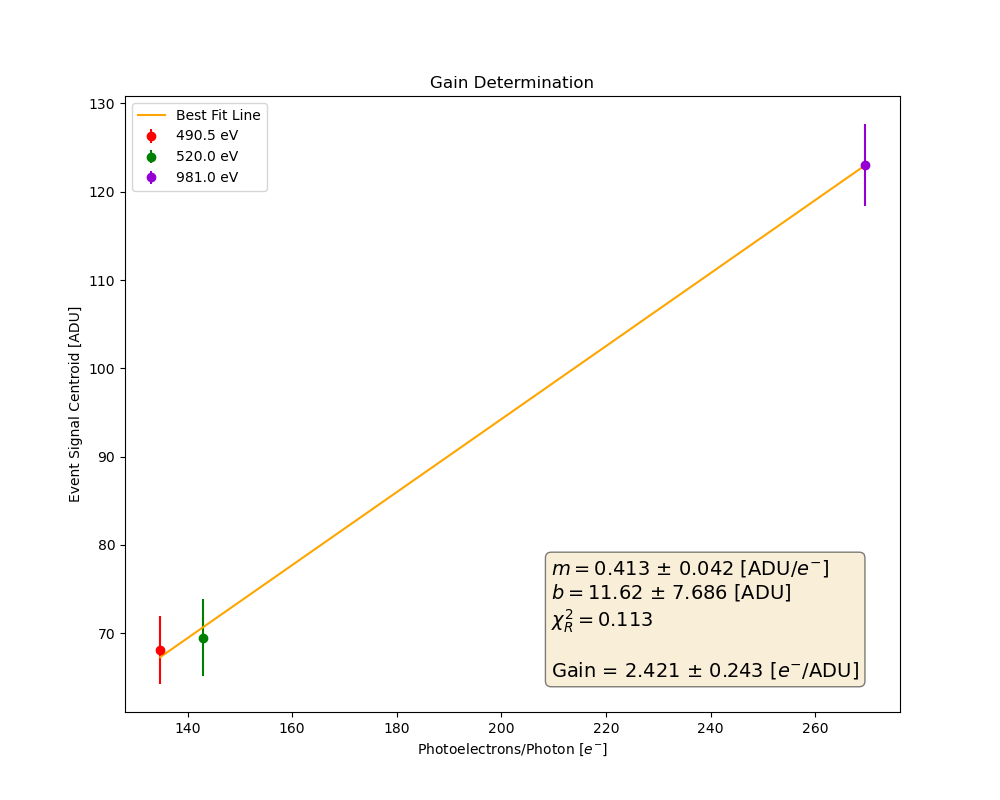

_________________________________
 Best Fit Parameters
 -----------------------------
 Slope: 0.41314 [ADU/e-]
 Slope Err: 0.04155 [ADU/e-]
 Gain: 2.421 [e-/ADU]
 Gain Err: 0.243 [e-/ADU]
 Reduced Chi Squared: 0.113


In [19]:
#Gain Determination First with SigmaADU as error
error = SigmaADU

Photoelectrons = Energies/wf

popt3, pcov3 = curve_fit(line, Photoelectrons, CentroidsADU, sigma=error, absolute_sigma=True)
perr3 = np.sqrt(np.diag(pcov3))

Slope = popt3[0]
SlopeErr = perr3[0]

b = popt3[1]
bErr = perr3[1]

Gain = 1/Slope
GainErr = SlopeErr/(Slope**2)

DataArray = CentroidsADU
ErrorArray = error
FitArray = line(Photoelectrons, *popt3)
NumberOfFitParameters = 2
ChiSquared, ReducedChiSquared, dof = ChiSquaredOfFit1D(DataArray,ErrorArray,FitArray,NumberOfFitParameters)

plt.figure(figsize=(10,8))
plt.clf()

ax=plt.gca()

SlopeString = str(round(Slope,3))
SlopeErrString = str(round(SlopeErr,3))
bString = str(round(b,3))
bErrString = str(round(bErr,3))
GainString = str(round(Gain,3))
GainErrString = str(round(GainErr,3))

ReducedChiSquaredString = str(round(ReducedChiSquared,3))


textstr = '\n'.join((
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " [ADU/$e^{-}$]",
    r'$b = $' + bString + " $\pm$ " + bErrString + " [ADU]",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString,
    r' ',
    r'Gain = ' + GainString + " $\pm$ " + GainErrString + " [$e^{-}$/ADU]"))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#plt.errorbar(Photoelectrons,CentroidsADU, yerr=SigmaADU, fmt = 'o', color = 'blue', label = 'ADU Centroids')
plt.errorbar([Photoelectrons[0]],[CentroidsADU[0]], yerr=[error[0]], fmt = 'o', color = 'red', label = '490.5 eV')
plt.errorbar([Photoelectrons[1]],[CentroidsADU[1]], yerr=[error[1]], fmt = 'o', color = 'green', label = '520.0 eV')
plt.errorbar([Photoelectrons[2]],[CentroidsADU[2]], yerr=[error[2]], fmt = 'o', color = 'darkviolet', label = '981.0 eV')
plt.plot(Photoelectrons, line(Photoelectrons, *popt3), color = 'orange', label = 'Best Fit Line')

#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        #verticalalignment='top', bbox=props)

ax.text(0.55, 0.25, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Gain Determination')
plt.xlabel('Photoelectrons/Photon [$e^{-}$]')
plt.ylabel('Event Signal Centroid [ADU]')
plt.legend()
plt.show()



print("_________________________________")
print(" Best Fit Parameters")
print(" -----------------------------")
print(" Slope: " + str(round(Slope,5)) + " [ADU/e-]")
print(" Slope Err: " + str(round(SlopeErr,5)) + " [ADU/e-]")
print(" Gain: " + str(round(Gain,3)) + " [e-/ADU]")
print(" Gain Err: " + str(round(GainErr,3)) + " [e-/ADU]")
print(" Reduced Chi Squared: " + ReducedChiSquaredString)

  0%|          | 0/3 [00:00<?, ?it/s]

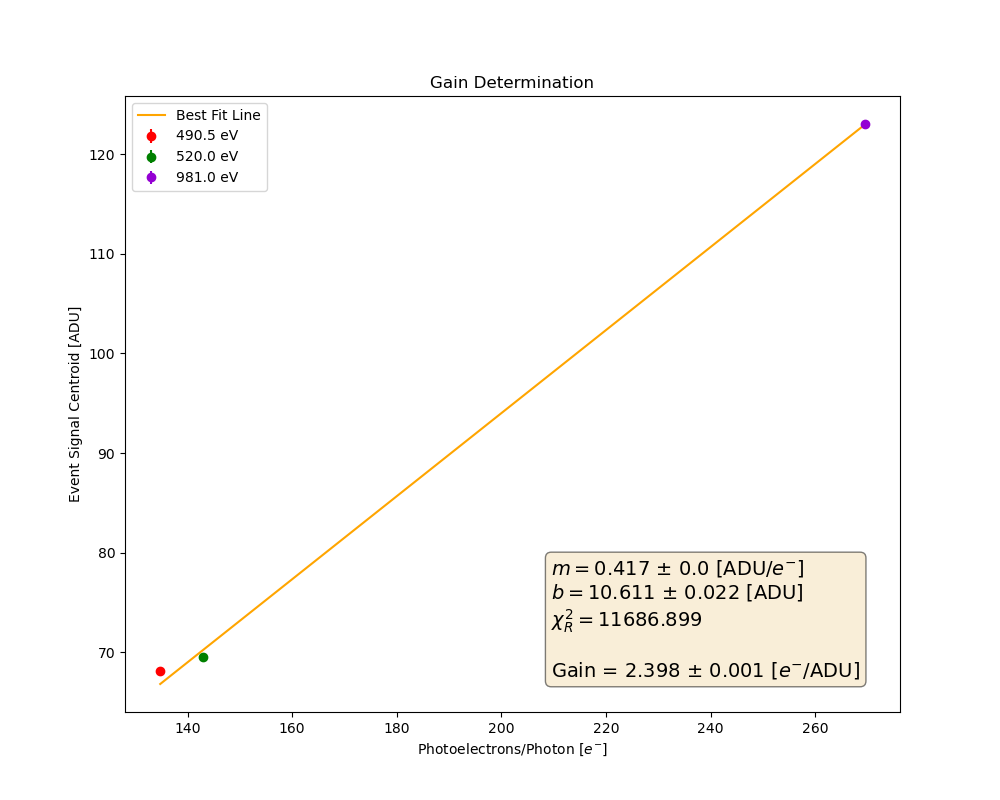

_________________________________
 Best Fit Parameters
 -----------------------------
 Slope: 0.41698 [ADU/e-]
 Slope Err: 0.00011 [ADU/e-]
 Gain: 2.398 [e-/ADU]
 Gain Err: 0.001 [e-/ADU]
 Reduced Chi Squared: 11686.899


In [20]:
#Gain Determination Second With CentroidsErrADU as error
error = CentroidsErrADU

Photoelectrons = Energies/wf

popt3, pcov3 = curve_fit(line, Photoelectrons, CentroidsADU, sigma=error, absolute_sigma=True)
perr3 = np.sqrt(np.diag(pcov3))

Slope = popt3[0]
SlopeErr = perr3[0]

b = popt3[1]
bErr = perr3[1]

Gain = 1/Slope
GainErr = SlopeErr/(Slope**2)

DataArray = CentroidsADU
ErrorArray = error
FitArray = line(Photoelectrons, *popt3)
NumberOfFitParameters = 2
ChiSquared, ReducedChiSquared, dof = ChiSquaredOfFit1D(DataArray,ErrorArray,FitArray,NumberOfFitParameters)

plt.figure(figsize=(10,8))
plt.clf()

ax=plt.gca()

SlopeString = str(round(Slope,3))
SlopeErrString = str(round(SlopeErr,3))
bString = str(round(b,3))
bErrString = str(round(bErr,3))
GainString = str(round(Gain,3))
GainErrString = str(round(GainErr,3))

ReducedChiSquaredString = str(round(ReducedChiSquared,3))


textstr = '\n'.join((
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " [ADU/$e^{-}$]",
    r'$b = $' + bString + " $\pm$ " + bErrString + " [ADU]",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString,
    r' ',
    r'Gain = ' + GainString + " $\pm$ " + GainErrString + " [$e^{-}$/ADU]"))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#plt.errorbar(Photoelectrons,CentroidsADU, yerr=SigmaADU, fmt = 'o', color = 'blue', label = 'ADU Centroids')
plt.errorbar([Photoelectrons[0]],[CentroidsADU[0]], yerr=[error[0]], fmt = 'o', color = 'red', label = '490.5 eV')
plt.errorbar([Photoelectrons[1]],[CentroidsADU[1]], yerr=[error[1]], fmt = 'o', color = 'green', label = '520.0 eV')
plt.errorbar([Photoelectrons[2]],[CentroidsADU[2]], yerr=[error[2]], fmt = 'o', color = 'darkviolet', label = '981.0 eV')
plt.plot(Photoelectrons, line(Photoelectrons, *popt3), color = 'orange', label = 'Best Fit Line')

#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        #verticalalignment='top', bbox=props)

ax.text(0.55, 0.25, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Gain Determination')
plt.xlabel('Photoelectrons/Photon [$e^{-}$]')
plt.ylabel('Event Signal Centroid [ADU]')
plt.legend()
plt.show()



print("_________________________________")
print(" Best Fit Parameters")
print(" -----------------------------")
print(" Slope: " + str(round(Slope,5)) + " [ADU/e-]")
print(" Slope Err: " + str(round(SlopeErr,5)) + " [ADU/e-]")
print(" Gain: " + str(round(Gain,3)) + " [e-/ADU]")
print(" Gain Err: " + str(round(GainErr,3)) + " [e-/ADU]")
print(" Reduced Chi Squared: " + ReducedChiSquaredString)

In [29]:
for Multiplier in np.arange(75.0,125.0,1.0):
    error = CentroidsErrADU*Multiplier

    Photoelectrons = Energies/wf

    popt3, pcov3 = curve_fit(line, Photoelectrons, CentroidsADU, sigma=error, absolute_sigma=True)
    perr3 = np.sqrt(np.diag(pcov3))

    Slope = popt3[0]
    SlopeErr = perr3[0]

    b = popt3[1]
    bErr = perr3[1]

    Gain = 1/Slope
    GainErr = SlopeErr/(Slope**2)

    DataArray = CentroidsADU
    ErrorArray = error
    FitArray = line(Photoelectrons, *popt3)
    NumberOfFitParameters = 2
    ChiSquared, ReducedChiSquared, dof = ChiSquaredOfFit1D_NoProgressBar(DataArray,ErrorArray,FitArray,NumberOfFitParameters)

    ReducedChiSquaredString = str(round(ReducedChiSquared,3))
    
    print("Multipler: " + str(round(Multiplier,1)) +", Reduced Chi Squared: " + ReducedChiSquaredString)
    

Multipler: 75.0, Reduced Chi Squared: 2.078
Multipler: 76.0, Reduced Chi Squared: 2.023
Multipler: 77.0, Reduced Chi Squared: 1.971
Multipler: 78.0, Reduced Chi Squared: 1.921
Multipler: 79.0, Reduced Chi Squared: 1.873
Multipler: 80.0, Reduced Chi Squared: 1.826
Multipler: 81.0, Reduced Chi Squared: 1.781
Multipler: 82.0, Reduced Chi Squared: 1.738
Multipler: 83.0, Reduced Chi Squared: 1.696
Multipler: 84.0, Reduced Chi Squared: 1.656
Multipler: 85.0, Reduced Chi Squared: 1.618
Multipler: 86.0, Reduced Chi Squared: 1.58
Multipler: 87.0, Reduced Chi Squared: 1.544
Multipler: 88.0, Reduced Chi Squared: 1.509
Multipler: 89.0, Reduced Chi Squared: 1.475
Multipler: 90.0, Reduced Chi Squared: 1.443
Multipler: 91.0, Reduced Chi Squared: 1.411
Multipler: 92.0, Reduced Chi Squared: 1.381
Multipler: 93.0, Reduced Chi Squared: 1.351
Multipler: 94.0, Reduced Chi Squared: 1.323
Multipler: 95.0, Reduced Chi Squared: 1.295
Multipler: 96.0, Reduced Chi Squared: 1.268
Multipler: 97.0, Reduced Chi Squa

  0%|          | 0/3 [00:00<?, ?it/s]

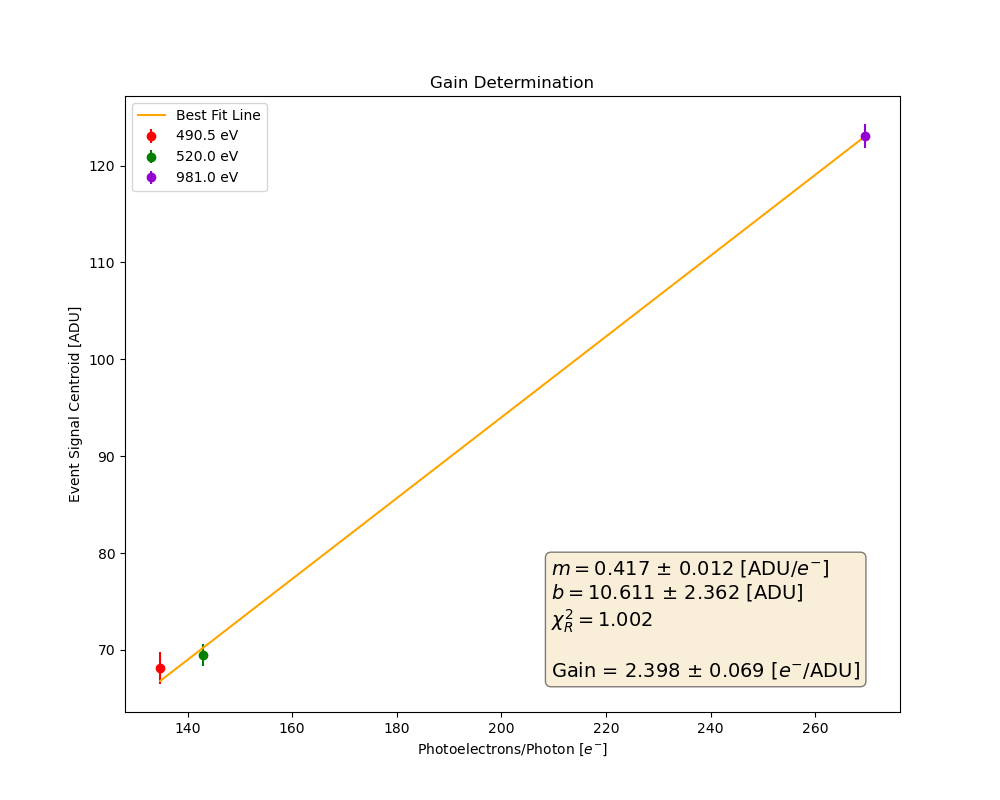

_________________________________
 Best Fit Parameters
 -----------------------------
 Slope: 0.41698 [ADU/e-]
 Slope Err: 0.01202 [ADU/e-]
 Gain: 2.398 [e-/ADU]
 Gain Err: 0.069 [e-/ADU]
 Reduced Chi Squared: 1.002


In [30]:
#Gain Determination CentroidsErrADU as error, now multiply erros by a factor of 108 to get a reduced chi squared close to 1 

error = CentroidsErrADU*108

Photoelectrons = Energies/wf

popt3, pcov3 = curve_fit(line, Photoelectrons, CentroidsADU, sigma=error, absolute_sigma=True)
perr3 = np.sqrt(np.diag(pcov3))

Slope = popt3[0]
SlopeErr = perr3[0]

b = popt3[1]
bErr = perr3[1]

Gain = 1/Slope
GainErr = SlopeErr/(Slope**2)

DataArray = CentroidsADU
ErrorArray = error
FitArray = line(Photoelectrons, *popt3)
NumberOfFitParameters = 2
ChiSquared, ReducedChiSquared, dof = ChiSquaredOfFit1D(DataArray,ErrorArray,FitArray,NumberOfFitParameters)

ReducedChiSquaredString = str(round(ReducedChiSquared,3))

plt.figure(figsize=(10,8))
plt.clf()

ax=plt.gca()

SlopeString = str(round(Slope,3))
SlopeErrString = str(round(SlopeErr,3))
bString = str(round(b,3))
bErrString = str(round(bErr,3))
GainString = str(round(Gain,3))
GainErrString = str(round(GainErr,3))




textstr = '\n'.join((
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " [ADU/$e^{-}$]",
    r'$b = $' + bString + " $\pm$ " + bErrString + " [ADU]",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString,
    r' ',
    r'Gain = ' + GainString + " $\pm$ " + GainErrString + " [$e^{-}$/ADU]"))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#plt.errorbar(Photoelectrons,CentroidsADU, yerr=SigmaADU, fmt = 'o', color = 'blue', label = 'ADU Centroids')
plt.errorbar([Photoelectrons[0]],[CentroidsADU[0]], yerr=[error[0]], fmt = 'o', color = 'red', label = '490.5 eV')
plt.errorbar([Photoelectrons[1]],[CentroidsADU[1]], yerr=[error[1]], fmt = 'o', color = 'green', label = '520.0 eV')
plt.errorbar([Photoelectrons[2]],[CentroidsADU[2]], yerr=[error[2]], fmt = 'o', color = 'darkviolet', label = '981.0 eV')
plt.plot(Photoelectrons, line(Photoelectrons, *popt3), color = 'orange', label = 'Best Fit Line')

#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        #verticalalignment='top', bbox=props)

ax.text(0.55, 0.25, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Gain Determination')
plt.xlabel('Photoelectrons/Photon [$e^{-}$]')
plt.ylabel('Event Signal Centroid [ADU]')
plt.legend()
plt.show()



print("_________________________________")
print(" Best Fit Parameters")
print(" -----------------------------")
print(" Slope: " + str(round(Slope,5)) + " [ADU/e-]")
print(" Slope Err: " + str(round(SlopeErr,5)) + " [ADU/e-]")
print(" Gain: " + str(round(Gain,3)) + " [e-/ADU]")
print(" Gain Err: " + str(round(GainErr,3)) + " [e-/ADU]")
print(" Reduced Chi Squared: " + ReducedChiSquaredString)

In [31]:
error = CentroidsErrADU*108
print(error)

[1.63837233 1.12930857 1.24722563]


In [139]:
#use the now known gain to determine the energy of the secondary peak for the 981 data

centroid_ADU_value = 71.595
photoelectron_equivalant = Gain*centroid_ADU_value
photon_energy = photoelectron_equivalant*wf
print(str(round(photon_energy,3)))


630.799
